In [1]:
;pwd

/Users/Jorge/projects/Apophis/notebooks


In [2]:
]activate ..

In [3]:
using Revise

In [4]:
using Apophis

┌ Info: Precompiling Apophis [b41c07a2-2abb-11e9-070a-c3c1b239e7df]
└ @ Base loading.jl:1186
┌ Info: Recompiling stale cache file /Users/Jorge/.julia/compiled/v1.1/AstroTime/buID8.ji for AstroTime [c61b5328-d09d-5e37-a9a8-0eb41c39009c]
└ @ Base loading.jl:1184


length(methods(RNp1BP_pN_A_J23E_J2S_ng_eph!)) = 1
length(methods(TaylorIntegration.jetcoeffs!)) = 3
methods(RNp1BP_pN_A_J23E_J2S_ng_eph!) = # 1 method for generic function "RNp1BP_pN_A_J23E_J2S_ng_eph!":
[1] RNp1BP_pN_A_J23E_J2S_ng_eph!(t, q, dq) in Apophis at /Users/Jorge/projects/Apophis/src/asteroid_dynamical_models.jl:17


In [5]:
# using TaylorIntegration, LinearAlgebra # Apophis.jl @reexports TaylorIntegration and LinearAlgebra
using Plots, DelimitedFiles, Dates
using Statistics: mean, std
using AstroTime
using Printf

┌ Info: Recompiling stale cache file /Users/Jorge/.julia/compiled/v1.1/Plots/ld3vC.ji for Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1184


Load Sun, 8 planets, Moon, Pluto and 16 asteroid ephemeris, previously integrated with TaylorIntegration.jl

In [6]:
using JLD

In [7]:
ss16asteph = load(joinpath(Apophis.jplephpath, "ss16ast343_eph.jld"), "ss16ast_eph");
#ss16asteph = load(joinpath(Apophis.jplephpath, "ss16ast100_eph.jld"), "ss16ast_eph");

Load Apophis ephemeris (also integrated previously with TaylorIntegration.jl); dynamical model includes: post-Newtonian interactions with Sun, 8 planets, Moon, Pluto, and 16 asteroids (same as those included in JPL's solution #199 for Apophis). It also includes interaction with Earth's J2 and J3. Earth's orientation model is the same as DE430/431.

In [8]:
#recover integration from .jld file
vars = ["interp"] #names of variables
filename = string("Apophis_jt_after_Folkner_errata.jld")
#filename = string("Apophis_jt_sseph_interp.jld")
for i in eachindex(vars)
    ex = Symbol(vars[i])
    @eval $ex = load($filename, vars[$i])
end
@show interp.t[1]
const t0 = interp.t[1]
#tv1 = interp.t

interp.t[1] = 2.4547335e6


2.4547335e6

In [9]:
apophis = deepcopy(interp);

In [10]:
apophis_et(et) = apophis( etsecs2julian(et) )[1:6]
earth_et(et) = ss16asteph( etsecs2julian(et) )[union(3*4-2:3*4,3*(27+4)-2:3*(27+4))]
sun_et(et) = ss16asteph( etsecs2julian(et) )[union(3*1-2:3*1,3*(27+1)-2:3*(27+1))]

sun_et (generic function with 1 method)

In [11]:
apophis(t0+4yr)

7-element Array{Taylor1{Float64},1}:
        0.6995945507688944 - 1.546174324396254e-8 t - 1.0969196521864808e-15 t² + 8.94701915814187e-24 t³ + 4.314020524905099e-31 t⁴ - 3.93601261986922e-39 t⁵ - 1.8631105728256223e-46 t⁶ + 1.8797735363882724e-54 t⁷ + 8.476754085378028e-62 t⁸ + 1.3704651709780962e-69 t⁹ - 1.9198003561684128e-76 t¹⁰ + 𝒪(t¹¹)
      - 0.24967182365139196 - 3.99906313863898e-8 t + 3.8359853104414766e-16 t² + 2.045434725213104e-23 t³ - 1.8323862926128553e-31 t⁴ - 8.081486639729814e-39 t⁵ + 7.547348742112811e-47 t⁶ + 4.252883061321573e-54 t⁷ - 4.187027371470012e-62 t⁸ - 3.743844767033684e-69 t⁹ + 2.4203430443516466e-76 t¹⁰ + 𝒪(t¹¹)
  - 0.07504168663147161 - 1.5272913183001537e-8 t + 1.1455387116169858e-16 t² + 7.839764819014201e-24 t³ - 5.715379075422726e-32 t⁴ - 3.1039352057549153e-39 t⁵ + 2.3247049234263396e-47 t⁶ + 1.6132956273266162e-54 t⁷ - 1.029834865609658e-62 t⁸ - 1.678456659434436e-69 t⁹ + 1.0489663354170633e-76 t¹⁰ + 𝒪(t¹¹)
      0.007999254352781168 + 1.03660423

In [12]:
apophis(t0+5yr)

7-element Array{Taylor1{Float64},1}:
  0.6120443967049045 + 3.656288549978818e-8 t - 1.5276008613904629e-15 t² + 3.3875844754015727e-23 t³ + 4.2061072092126054e-29 t⁴ + 1.5173014338313496e-35 t⁵ + 4.0783554660775754e-42 t⁶ + 5.142882627449147e-49 t⁷ - 2.3988749636165405e-55 t⁸ - 2.3064430228275598e-61 t⁹ - 1.5617547702560427e-67 t¹⁰ + 𝒪(t¹¹)
      0.5330383040248536 - 4.8791145402409326e-8 t - 1.5234870639480413e-15 t² - 9.976193309533995e-23 t³ - 7.299399982582164e-29 t⁴ - 3.0422216486613367e-35 t⁵ - 9.489680940751957e-42 t⁶ - 1.9224775508401437e-48 t⁷ + 7.931385354392116e-56 t⁸ + 3.234734958388495e-61 t⁹ + 2.290611227480112e-67 t¹⁰ + 𝒪(t¹¹)
      0.2135812548510632 - 1.728014966148916e-8 t - 6.337242879861672e-16 t² - 4.411193636927824e-23 t³ - 2.741981403685427e-29 t⁴ - 1.0695832405331497e-35 t⁵ - 3.0883385075943853e-42 t⁶ - 5.1362895220387965e-49 t⁷ + 9.938700008801754e-56 t⁸ + 1.3779919711647459e-61 t⁹ + 8.880020194274311e-68 t¹⁰ + 𝒪(t¹¹)
      - 0.010794579871278095 + 1.006034689

Load Apophis radar astrometry, downloaded from JPL's radar astrometry website: https://ssd.jpl.nasa.gov/?radar

In [13]:
apophis_radar_data_2005_2013 = process_radar_data_jpl("../Apophis_JPL_data.dat");

Construct vector of observation times in UTC and TDB:

In [14]:
#construct vector of observation times (UTC)
tv_jpl_utc = UTCEpoch.([x.utcepoch for x in apophis_radar_data_2005_2013])
# convert to TDB
tv_jpl_tdb = TDBEpoch.(tv_jpl_utc)
# date/time to Julian date
tv_jpl_tdb_julian =  map(x->x.Δt, julian.(tv_jpl_tdb))
# construct time range variable with t0 and observation times > t0, removing repeated values
tv = union(t0, tv_jpl_tdb_julian[tv_jpl_tdb_julian .> t0])
@show all(diff(tv) .> 0)

all(diff(tv) .> 0) = true


true

Take only observations from 2012-2013:

In [15]:
apophis_data = apophis_radar_data_2005_2013[6:end] #take only the 2012-2013 subset

29-element Array{RadarDataJPL{Float64},1}:
 RadarDataJPL{Float64}("99942 Apophis (2004 MN4)", 2012-12-21T11:10:00, NaN, NaN, "X", 57992.443, 0.25, "Hz", 8560.0, 253, 253, "C")               
 RadarDataJPL{Float64}("99942 Apophis (2004 MN4)", 2012-12-22T11:00:00, 1.0268298605e8, 0.25, "us", 57880.25, 0.1, "Hz", 8560.0, 253, 253, "C")    
 RadarDataJPL{Float64}("99942 Apophis (2004 MN4)", 2013-01-03T09:20:00, 9.744910761e7, 0.25, "us", 36629.285, 0.1, "Hz", 8560.0, 253, 253, "C")    
 RadarDataJPL{Float64}("99942 Apophis (2004 MN4)", 2013-01-03T10:00:00, 9.743930871e7, 3.0, "us", NaN, NaN, "X", 8560.0, 253, 253, "C")            
 RadarDataJPL{Float64}("99942 Apophis (2004 MN4)", 2013-01-03T10:50:00, 9.742842546e7, 0.25, "us", NaN, NaN, "X", 8560.0, 253, 253, "C")           
 RadarDataJPL{Float64}("99942 Apophis (2004 MN4)", 2013-01-05T08:40:00, NaN, NaN, "X", 30404.009, 0.2, "Hz", 8560.0, 253, 253, "C")                
 RadarDataJPL{Float64}("99942 Apophis (2004 MN4)", 2013-01-05T10:40:0

Check that each receiver and transmitter antennas are the same (i.e., monostatic mode):

In [16]:
@show all( ismonostatic.(apophis_data) )

all(ismonostatic.(apophis_data)) = true


true

Get the station (observatories) codes:

In [17]:
#then, get the station codes
station_codes = [x.rcvr for x in apophis_data];

Get transmission frequencies (MHz):

In [18]:
#extract transmitter frequencies (MHz)
transmitter_freq_MHz = [x.freq for x in apophis_data]

29-element Array{Float64,1}:
 8560.0
 8560.0
 8560.0
 8560.0
 8560.0
 8560.0
 8560.0
 8560.0
 8560.0
 8560.0
 8560.0
 8560.0
 8560.0
    ⋮  
 8560.0
 8560.0
 8560.0
 8560.0
 8560.0
 2380.0
 2380.0
 2380.0
 2380.0
 2380.0
 2380.0
 2380.0

Get UTC receive times:

In [19]:
# get UTC receive times
tv_jpl_utc_jul = [datetime2julian(x.utcepoch) for x in apophis_data];

Get indices of delay and Doppler observations in `apophis_data`:

In [20]:
delay_index = findall(x->x.delay_units=="us", apophis_data)
doppler_index = findall(x->x.doppler_units=="Hz", apophis_data);

# Delay/Doppler observations reduction

In [21]:
niters = 3 # number of iterations in time delay recursive process
rad_ind = 2

2

In [22]:
station_codes[rad_ind]

253

In [23]:
UTCEpoch.(TDBEpoch.(tv, origin=:julian))

30-element Array{Epoch{UTC,Float64},1}:
 2008-09-23T23:58:54.818 UTC 
 2012-12-21T11:10:00.000 UTC 
 2012-12-22T11:00:00.000 UTC 
 2013-01-03T09:19:59.1000 UTC
 2013-01-03T10:00:00.000 UTC 
 2013-01-03T10:49:59.1000 UTC
 2013-01-05T08:39:59.1000 UTC
 2013-01-05T10:40:00.000 UTC 
 2013-01-05T10:50:00.000 UTC 
 2013-01-06T08:20:00.000 UTC 
 2013-01-06T09:29:59.1000 UTC
 2013-01-08T08:10:00.000 UTC 
 2013-01-09T07:59:59.1000 UTC
 ⋮                           
 2013-01-14T09:50:00.000 UTC 
 2013-01-15T06:30:00.000 UTC 
 2013-01-16T06:29:59.1000 UTC
 2013-01-16T07:49:59.1000 UTC
 2013-01-17T06:19:59.1000 UTC
 2013-02-18T00:56:00.000 UTC 
 2013-02-18T01:37:00.000 UTC 
 2013-02-19T01:07:59.1000 UTC
 2013-02-20T00:37:59.1000 UTC
 2013-02-20T01:26:00.000 UTC 
 2013-02-21T01:03:59.1000 UTC
 2013-03-15T23:58:59.1000 UTC

In [24]:
apophis_data[rad_ind].utcepoch

2012-12-22T11:00:00

In [25]:
apophis_data[rad_ind].freq

8560.0

In [31]:
tdelay, dshift = delay_doppler(
    apophis_data[rad_ind].rcvr,
    apophis_data[rad_ind].utcepoch,
    apophis_data[rad_ind].freq,
    niters,
    xve = earth_et,
    xvs = sun_et,
    xva = apophis_et
)

( 1.0268279556588998e8 - 33.055968155821176 t + 1.7766789793148076e-6 t² + 6.170936324454168e-13 t³ + 1.827571704921038e-19 t⁴ + 4.8109422099009663e-26 t⁵ + 1.0459934164111698e-32 t⁶ + 1.4342146664846398e-39 t⁷ - 1.712937123049663e-46 t⁸ - 2.2835040490573932e-52 t⁹ - 1.0897023680232373e-58 t¹⁰ + 𝒪(t¹¹),  57879.983286271665 - 0.03517778583509415 t - 7.508810022015262e-9 t² - 2.056545465661628e-15 t³ - 4.243066347167357e-22 t⁴ - 2.007791763680501e-29 t⁵ + 3.7333176247626153e-35 t⁶ + 2.4915801220455075e-41 t⁷ + 1.0578223749533248e-47 t⁸ + 3.3700201467814465e-54 t⁹ + 7.371009374375196e-61 t¹⁰ + 𝒪(t¹¹))

In [32]:
tdelay(-5.747127431260697), dshift(-5.747127431260697)

(1.0268298554281002e8, 57880.1854572416)

In [33]:
tdelay_jpl, dshift_jpl = delay_doppler(
    apophis_data[rad_ind].rcvr,
    apophis_data[rad_ind].utcepoch,
    apophis_data[rad_ind].freq,
    niters
)

(1.0268298563152787e8, 57880.18334641935)

In [34]:
apophis_data[rad_ind].delay #DELAY observed value

1.0268298605e8

In [35]:
tdelay_jpl #DELAY computed value, JPL

1.0268298563152787e8

In [36]:
apophis_data[rad_ind].delay - tdelay_jpl #DELAY O-C, JPL

0.41847212612628937

In [37]:
tdelay() #DELAY computed value, TaylorIntegration.jl, with A2=0

1.0268279556588998e8

In [38]:
apophis_data[rad_ind].delay - tdelay() #DELAY O-C, TaylorIntegration, with A2=0

190.4841100126505

In [39]:
apophis_data[rad_ind].delay - tdelay(-5.747127431260697) #DELAY O-C, TaylorIntegration, with A2=-5.7

0.5071899741888046

In [40]:
apophis_data[rad_ind].doppler #DOPPLER observed value

57880.25

In [41]:
dshift_jpl #DOPPLER computed value, JPL

57880.18334641935

In [42]:
apophis_data[rad_ind].doppler - dshift_jpl #DOPPLER O-C, JPL

0.06665358065220062

In [43]:
dshift() #DOPPLER computed value, TaylorIntegration.jl, with A2=0

57879.983286271665

In [44]:
apophis_data[rad_ind].doppler - dshift() #DELAY O-C, TaylorIntegration, with A2=0

0.26671372833516216

In [45]:
apophis_data[rad_ind].doppler - dshift(-5.747127431260697) #DELAY O-C, TaylorIntegration, with A2=-5.7

0.06454275840224

In [46]:
#get time-delay, Doppler-shift values from integration

tdelay_v1 = Array{Taylor1{Float64}}(undef, length(apophis_data))
dshift_v1 = Array{Taylor1{Float64}}(undef, length(apophis_data))

for i in eachindex(apophis_data)
    tdelay_v1[i], dshift_v1[i] = delay_doppler(
        apophis_data[i].rcvr,
        apophis_data[i].utcepoch,
        apophis_data[i].freq,
        niters,
        xve = earth_et,
        xvs = sun_et,
        xva = apophis_et
    )
end

In [47]:
# compute time-delay, Doppler-shift values from JPL ephemerides

tdelay_JPL_v1 = Array{Float64}(undef, length(apophis_data))
dshift_JPL_v1 = Array{Float64}(undef, length(apophis_data))

for i in eachindex(apophis_data)
    tdelay_JPL_v1[i], dshift_JPL_v1[i] = delay_doppler(
        apophis_data[i].rcvr,
        apophis_data[i].utcepoch,
        apophis_data[i].freq,
        niters
    )
end

# Time-delay / Doppler shift plots

In [48]:
tdelay_jpl_obs = [x.delay for x in apophis_data][delay_index]
dshift_jpl_obs = [x.doppler for x in apophis_data][doppler_index]

tdelay_jpl_obs_sigma = [x.delay_sigma for x in apophis_data][delay_index]
dshift_jpl_obs_sigma = [x.doppler_sigma for x in apophis_data][doppler_index];

In [49]:
# Observed minus computed (O-C) residuals: JPL DE430+s199

# absolute
residual_JPL_td = tdelay_jpl_obs - tdelay_JPL_v1[delay_index]  # (usec)
residual_JPL_ds = dshift_jpl_obs - (dshift_JPL_v1[doppler_index]) # (Hz)

# relative
rel_res_JPL_td = residual_JPL_td ./ tdelay_jpl_obs # (usec)
rel_res_JPL_ds = residual_JPL_ds ./ dshift_jpl_obs # (Hz)
;

In [50]:
residual_JPL_td

15-element Array{Float64,1}:
  0.41847212612628937
  0.2975752204656601 
 -0.2110614776611328 
  0.3035794198513031 
  0.13318029046058655
 -0.3415873497724533 
  0.29785044491291046
  0.23189179599285126
  0.22453811764717102
  0.10712215304374695
  0.15350501239299774
 -0.33382798731327057
 -0.11434051394462585
  0.07137376070022583
  0.6646601855754852 

In [51]:
residual_JPL_ds

24-element Array{Float64,1}:
  0.1289058170877979  
  0.06665358065220062 
  0.033552018328919075
  0.13148816889952286 
 -0.06127582034241641 
 -0.03272410410500015 
  0.041691648337291554
 -0.00498742621675774 
 -0.006870573495689314
 -0.035070743275809946
  0.028768049900463666
  0.1139129113994386  
 -0.039577835912496084
  0.04097157889555092 
 -0.02791954990971135 
  0.13010889709403273 
  0.0638084058809909  
  0.5747190825204598  
  0.5328724694845732  
  0.597297199172317   
  0.607059450718225   
  0.6409663563972572  
  0.6500146325997775  
  0.7982820600300329  

In [52]:
#Observed minus computed (O-C) residuals: TaylorIntegration.jl

#absolute
residual_td = tdelay_jpl_obs - (tdelay_v1[delay_index])  # (usec)
residual_ds = dshift_jpl_obs - (dshift_v1[doppler_index]) # (Hz)

#relative
rel_res_td = residual_td ./ tdelay_jpl_obs # (usec)
rel_res_ds = residual_ds ./ dshift_jpl_obs # (Hz)
;

## Plots

In [53]:
gr()

Plots.GRBackend()

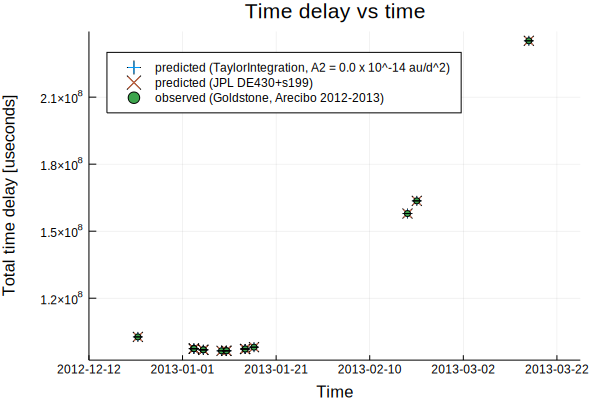

In [54]:
A2_plot = 0.0
scatter(
    tv_jpl_utc_jul[delay_index].-t0, tdelay_v1[delay_index](A2_plot),
    label="predicted (TaylorIntegration, A2 = $A2_plot x 10^-14 au/d^2)",
    marker=:cross
)
scatter!(
    tv_jpl_utc_jul[delay_index].-t0,
    tdelay_JPL_v1[delay_index],
    label="predicted (JPL DE430+s199)",
    marker=:xcross
)
scatter!(
    tv_jpl_utc_jul[delay_index].-t0,
    tdelay_jpl_obs,
    label="observed (Goldstone, Arecibo 2012-2013)",
    legend=:topleft,
    marker=:circle,
    markersize=3,
    yerror=dshift_jpl_obs_sigma
)
title!("Time delay vs time")
ylabel!("Total time delay [useconds]")
xlims!(1540, 1645)
xticks!(1540:20:1640, string.(Date.(julian2datetime.(t0 .+ collect(1540:20:1640)))))
xlabel!("Time")

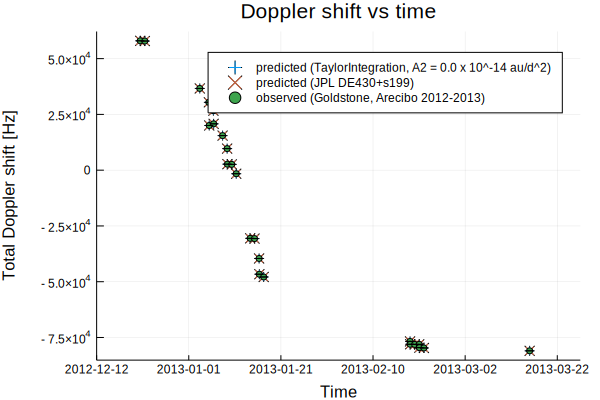

In [55]:
A2_plot = 0.0
scatter(
    tv_jpl_utc_jul[doppler_index].-t0, dshift_v1[doppler_index](A2_plot),
    label="predicted (TaylorIntegration, A2 = $A2_plot x 10^-14 au/d^2)",
    marker=:cross
)
scatter!(
    tv_jpl_utc_jul[doppler_index].-t0,
    dshift_JPL_v1[doppler_index],
    label="predicted (JPL DE430+s199)",
    marker=:xcross
)
scatter!(
    tv_jpl_utc_jul[doppler_index].-t0,
    dshift_jpl_obs,
    label="observed (Goldstone, Arecibo 2012-2013)",
    legend=:topright,
    marker=:circle,
    markersize=3,
    yerror=dshift_jpl_obs_sigma
)
title!("Doppler shift vs time")
ylabel!("Total Doppler shift [Hz]")
xlims!(1540, 1645)
xticks!(1540:20:1640, string.(Date.(julian2datetime.(t0 .+ collect(1540:20:1640)))))
xlabel!("Time")

In [56]:
A2_lsqfit_deldop
# -5.751341790851659

UndefVarError: UndefVarError: A2_lsqfit_deldop not defined

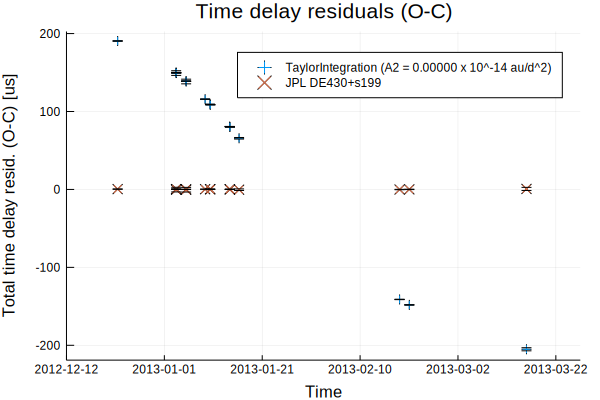

In [57]:
#A2_plot = -5.592839897872 # JPL solution #199
#A2_plot = -5.751341790851659 # A2_lsqfit_deldop
A2_plot = 0.0 #-5.7
A2_label_str = @sprintf "TaylorIntegration (A2 = %.5f x 10^-14 au/d^2)"  A2_plot
scatter(
    tv_jpl_utc_jul[delay_index].-t0,
    residual_td(A2_plot), yerror = tdelay_jpl_obs_sigma,
    marker=:cross,
    label = A2_label_str,
    legend = :topright
)
scatter!(
    tv_jpl_utc_jul[delay_index].-t0,
    residual_JPL_td, yerror = tdelay_jpl_obs_sigma,
    marker=:xcross,
    label = "JPL DE430+s199",
    legend = :topright
)
title!("Time delay residuals (O-C)")
ylabel!("Total time delay resid. (O-C) [us]")
xlims!(1540, 1645)
#ylims!(-215,210)
xticks!(1540:20:1640, string.(Date.(julian2datetime.(t0 .+ collect(1540:20:1640)))))
xlabel!("Time")
#savefig("delay_residuals_A2_0.pdf")
#savefig("delay_residuals_A2_lsfit.pdf")

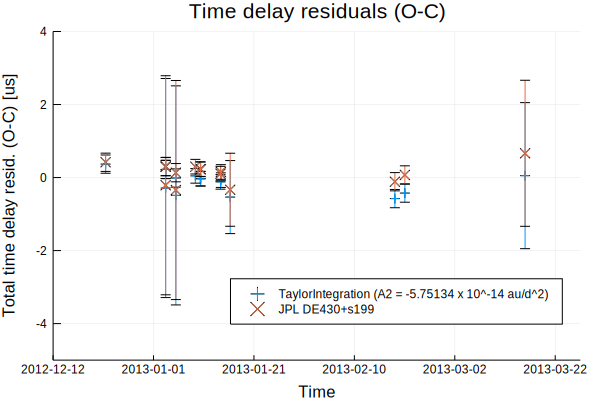

In [58]:
#A2_plot = -5.592839897872 # JPL solution #199
A2_plot = -5.751341790851659 # A2_lsqfit_deldop
#A2_plot = 0.0 #-5.7
A2_label_str = @sprintf "TaylorIntegration (A2 = %.5f x 10^-14 au/d^2)"  A2_plot
scatter(
    tv_jpl_utc_jul[delay_index].-t0,
    residual_td(A2_plot), yerror = tdelay_jpl_obs_sigma,
    marker=:cross,
    label = A2_label_str,
    legend = :topright
)
scatter!(
    tv_jpl_utc_jul[delay_index].-t0,
    residual_JPL_td, yerror = tdelay_jpl_obs_sigma,
    marker=:xcross,
    label = "JPL DE430+s199",
    legend = :bottomright
)
title!("Time delay residuals (O-C)")
ylabel!("Total time delay resid. (O-C) [us]")
xlims!(1540, 1645)
ylims!(-5,4)
xticks!(1540:20:1640, string.(Date.(julian2datetime.(t0 .+ collect(1540:20:1640)))))
xlabel!("Time")
#savefig("delay_residuals_A2_0.pdf")
#savefig("delay_residuals_A2_lsfit.pdf")

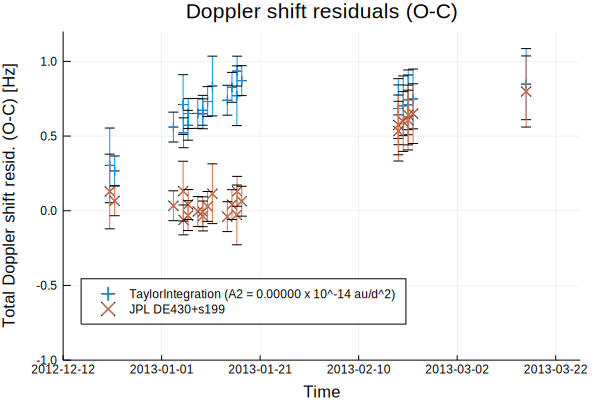

In [59]:
#A2_plot = -5.592839897872 # JPL solution #199
#A2_plot = -5.74846133680956 # A2_lsqfit_deldop
A2_plot = 0.0 #-5.7
A2_label_str = @sprintf "TaylorIntegration (A2 = %.5f x 10^-14 au/d^2)"  A2_plot
scatter(
    tv_jpl_utc_jul[doppler_index].-t0,
    residual_ds(A2_plot), yerror = dshift_jpl_obs_sigma,
    marker=:cross,
    label = A2_label_str,
    leg=false
)
scatter!(
    tv_jpl_utc_jul[doppler_index].-t0,
    residual_JPL_ds, yerror = dshift_jpl_obs_sigma,
    marker=:xcross,
    label = "JPL DE430+s199",
    legend=:bottomleft
)
title!("Doppler shift residuals (O-C)")
ylabel!("Total Doppler shift resid. (O-C) [Hz]")
xlims!(1540, 1645)
xticks!(1540:20:1640, string.(Date.(julian2datetime.(t0 .+ collect(1540:20:1640)))))
xlabel!("Time")
ylims!(-1.0,1.2)
#savefig("doppler_residuals_A2_0.pdf")
#savefig("doppler_residuals_A2_lsfit.pdf")

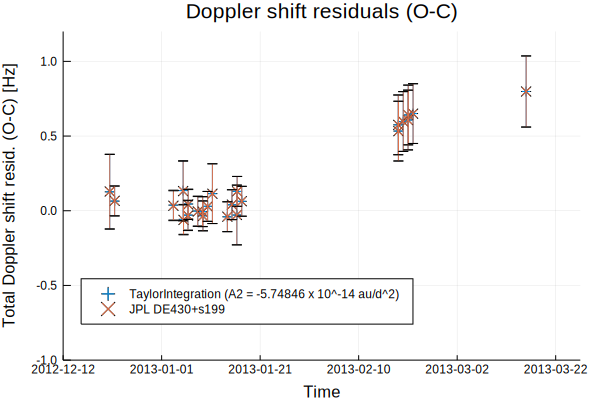

In [60]:
#A2_plot = -5.592839897872 # JPL solution #199
A2_plot = -5.74846133680956 # A2_lsqfit_deldop
#A2_plot = 0.0 #-5.7
A2_label_str = @sprintf "TaylorIntegration (A2 = %.5f x 10^-14 au/d^2)"  A2_plot
scatter(
    tv_jpl_utc_jul[doppler_index].-t0,
    residual_ds(A2_plot), yerror = dshift_jpl_obs_sigma,
    marker=:cross,
    label = A2_label_str,
    leg=false
)
scatter!(
    tv_jpl_utc_jul[doppler_index].-t0,
    residual_JPL_ds, yerror = dshift_jpl_obs_sigma,
    marker=:xcross,
    label = "JPL DE430+s199",
    legend=:bottomleft
)
title!("Doppler shift residuals (O-C)")
ylabel!("Total Doppler shift resid. (O-C) [Hz]")
xlims!(1540, 1645)
xticks!(1540:20:1640, string.(Date.(julian2datetime.(t0 .+ collect(1540:20:1640)))))
xlabel!("Time")
#ylims!(-0.6,0.5)
ylims!(-1.0,1.2)
#savefig("doppler_residuals_A2_0.pdf")
#savefig("doppler_residuals_A2_lsfit.pdf")

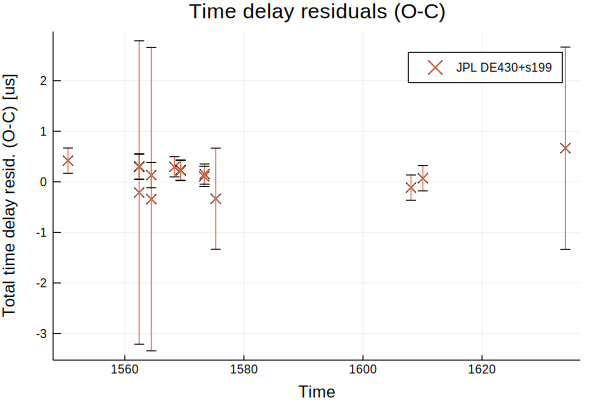

In [61]:
scatter(
    tv_jpl_utc_jul[delay_index].-t0, residual_JPL_td, yerror = tdelay_jpl_obs_sigma,
    marker=:xcross,
    label = "JPL DE430+s199",
    legend = :topright,
    color=2
)
ylabel!("Total time delay resid. (O-C) [us]")
#xlims!(1540, 1645)
#xticks!(1540:20:1640, string.(Date.(julian2datetime.(t0 .+ collect(1540:20:1640)))))
xlabel!("Time")
title!("Time delay residuals (O-C)")

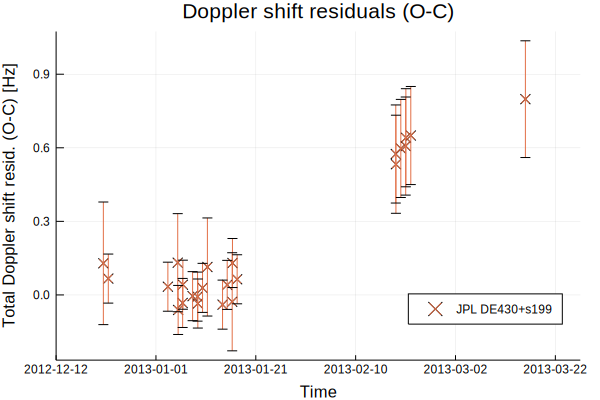

In [62]:
scatter(
    tv_jpl_utc_jul[doppler_index].-t0,
    residual_JPL_ds, yerror = dshift_jpl_obs_sigma,
    marker=:xcross,
    label = "JPL DE430+s199",
    legend=:bottomright,
    color=2
)
title!("Doppler shift residuals (O-C)")
ylabel!("Total Doppler shift resid. (O-C) [Hz]")
xlims!(1540, 1645)
xticks!(1540:20:1640, string.(Date.(julian2datetime.(t0 .+ collect(1540:20:1640)))))
xlabel!("Time")

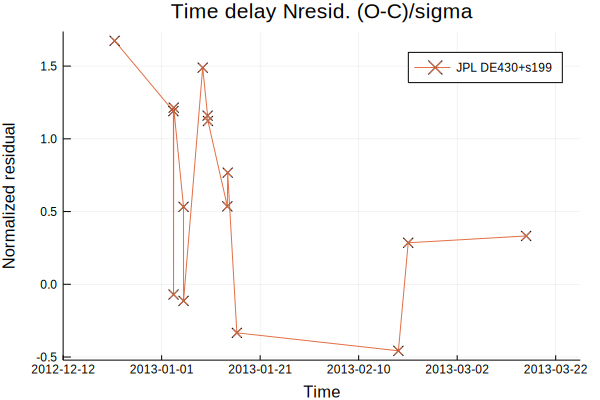

In [63]:
plot(
    tv_jpl_utc_jul[delay_index].-t0,
    residual_JPL_td./tdelay_jpl_obs_sigma,
    #yerror = tdelay_jpl_obs_sigma./tdelay_jpl_obs,
    label="JPL DE430+s199",
    marker=:xcross,
    legend=:topright,
    color=2
)
title!("Time delay Nresid. (O-C)/sigma")
xlims!(1540, 1645)
#ylims!(-1.1,1.1)
xticks!(1540:20:1640, string.(Date.(julian2datetime.(t0 .+ collect(1540:20:1640)))))
xlabel!("Time")
ylabel!("Normalized residual")

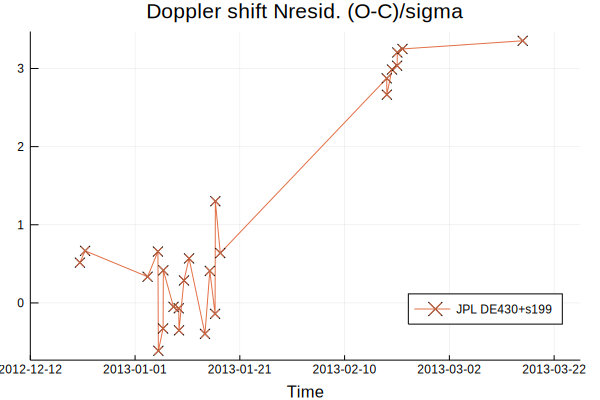

In [64]:
plot(
    tv_jpl_utc_jul[doppler_index].-t0,
    residual_JPL_ds./dshift_jpl_obs_sigma,
    #yerror = dshift_jpl_obs_sigma./dshift_jpl_obs,
    label="JPL DE430+s199",
    legend=:bottomright,
    marker=:xcross,
    color=2
)
title!("Doppler shift Nresid. (O-C)/sigma")
xlims!(1540, 1645)
#ylims!(-2, 2)
xticks!(1540:20:1640, string.(Date.(julian2datetime.(t0 .+ collect(1540:20:1640)))))
xlabel!("Time")

A2_plot = 0.0 #A2_lsqfit_del
scatter(
    tv_jpl_utc_jul[delay_index].-t0,
    rel_res_td(A2_plot),
    yerror = tdelay_jpl_obs_sigma./tdelay_jpl_obs,
    label="TaylorIntegration (A2 = $A2_plot x 10^-14 au/d^2)",
    marker=:cross,
    legend=:topright
)
scatter!(
    tv_jpl_utc_jul[delay_index].-t0,
    rel_res_JPL_td,
    yerror = tdelay_jpl_obs_sigma./tdelay_jpl_obs,
    label="JPL DE430+s199",
    marker=:xcross,
    legend=:topright
)
title!("Time delay relative resid. (O-C)/O")
xlims!(1540, 1645)
xticks!(1540:20:1640, string.(Date.(julian2datetime.(t0 .+ collect(1540:20:1640)))))
xlabel!("Time")

A2_plot = 0.0
scatter(
    tv_jpl_utc_jul[doppler_index].-t0,
    rel_res_ds(A2_plot),
    yerror = dshift_jpl_obs_sigma./dshift_jpl_obs,
    label="TaylorIntegration (A2 = $A2_plot x 10^-14 au/d^2)",
    legend=:bottomright,
    marker=:cross
)
scatter!(
    tv_jpl_utc_jul[doppler_index].-t0,
    rel_res_JPL_ds,
    yerror = dshift_jpl_obs_sigma./dshift_jpl_obs,
    label="JPL DE430+s199",
    legend=:bottomright,
    marker=:xcross
)
title!("Doppler shift relative resid. (O-C)/O")
xlims!(1540, 1645)
xticks!(1540:20:1640, string.(Date.(julian2datetime.(t0 .+ collect(1540:20:1640)))))
xlabel!("Time")

#check that HORIZONS (s#199) and downloaded SPK file for Apophis are the same
#according to this check, they differ at the end of the evaluated times by ~ 2m in position
tv_spkvhor = range(2454733.5, length=1001, stop=2456367.5)
apophis_spk_arr = Array{Float64}(undef, length(tv_spkvhor), 6)
for i in eachindex(tv_spkvhor)
    apophis_spk_arr[i,:] .= Apophis.apophis_pv(tv_spkvhor[i])
end
apophis_horizons_arr = readdlm("../wld103954.15")
@show norm((apophis_spk_arr .- apophis_horizons_arr)[end,1:3])
@show norm((apophis_spk_arr .- apophis_horizons_arr)[end,4:6])
;

# Yarkovsky $A_2$ coefficient estimation

Here, we will compute, for a single time delay observation, the value of $A_2$ which makes the O-C residual of that observation equal to zero:

In [65]:
#observed value
tdelay_jpl_obs[1]

1.0268298605e8

In [66]:
# computed value (full solution)
tdelay_v1[delay_index[1]] # τ_c(A2) = p(A2)

 1.0268279556588998e8 - 33.055968155821176 t + 1.7766789793148076e-6 t² + 6.170936324454168e-13 t³ + 1.827571704921038e-19 t⁴ + 4.8109422099009663e-26 t⁵ + 1.0459934164111698e-32 t⁶ + 1.4342146664846398e-39 t⁷ - 1.712937123049663e-46 t⁸ - 2.2835040490573932e-52 t⁹ - 1.0897023680232373e-58 t¹⁰ + 𝒪(t¹¹)

In [67]:
# residual (A2 = 0)
tdelay_jpl_obs[1] - tdelay_v1[delay_index[1]]()

190.4841100126505

In [68]:
# substract A2=0 solution from τ_c(A2) (i.e., compute τ_c(A2)-τ_c(A2=0) )
p_τ_1 = tdelay_v1[delay_index[1]]-tdelay_v1[delay_index[1]]()

 - 33.055968155821176 t + 1.7766789793148076e-6 t² + 6.170936324454168e-13 t³ + 1.827571704921038e-19 t⁴ + 4.8109422099009663e-26 t⁵ + 1.0459934164111698e-32 t⁶ + 1.4342146664846398e-39 t⁷ - 1.712937123049663e-46 t⁸ - 2.2835040490573932e-52 t⁹ - 1.0897023680232373e-58 t¹⁰ + 𝒪(t¹¹)

In [69]:
# Let p_τ_1(A2) be the above polynomial expression, then we invert it so we get A2(δτ):
A2_δτ_1 = inverse(p_τ_1)

 - 0.03025172323757516 t + 4.9188017586997044e-11 t² - 6.767898076772617e-19 t³ + 9.482425721071047e-27 t⁴ - 1.4019214324945446e-34 t⁵ + 2.16182372842218e-42 t⁶ - 3.447313705451376e-50 t⁷ + 5.6459765812085365e-58 t⁸ - 9.44739552307647e-66 t⁹ + 1.6086429112243107e-73 t¹⁰ + 𝒪(t¹¹)

In [70]:
#Now, we evaluate the polynomial at the corresponding residual at the A2=0 TaylorIntegration solution:
A2_δτ_1(residual_td[1]())

-5.76247079251552

Now, we follow the same strategy for all the 2012-2013 radar astrometry for Apohpis (delay and Doppler):

In [71]:
td_us = tdelay_v1[delay_index]
ds_Hz = dshift_v1[doppler_index];

In [72]:
A2_δτ_v = (  inverse.( td_us-td_us() )  ) # vector of A2(δτ) polynomials at each delay observation;
A2_δν_v = (  inverse.( ds_Hz-ds_Hz() )  ) # vector of A2(δν) polynomials at each Doppler observation;

In [73]:
A2_del_v = map((x,y)->x(y), A2_δτ_v, residual_td()); # A2(δτ) polynomials evaluated at the O-C time delay residuals;
A2_dop_v = map((x,y)->x(y), A2_δν_v, residual_ds()); # A2(δν) polynomials evaluated at the O-C Doppler shift residuals;

In [74]:
A2_del_v

15-element Array{Float64,1}:
 -5.76247079251552 
 -5.759860870468456
 -5.740304599074605
 -5.759868643791216
 -5.750805999985048
 -5.731132919296619
 -5.75365755853765 
 -5.749893504937906
 -5.749507821694209
 -5.74293781584091 
 -5.746273708482464
 -5.704856043300142
 -5.774919833611218
 -5.767903576253135
 -5.749879957982837

In [75]:
A2_dop_v

24-element Array{Float64,1}:
  -9.85945608698969  
  -7.581891629823267 
  -6.163245922740102 
  -7.098124055588199 
  -5.177156616897998 
  -5.4688640248329135
  -6.177011104904771 
  -5.73158376242128  
  -5.704117989357211 
  -5.466638301138465 
  -5.991196810645434 
  -6.663756146847791 
  -5.449569476087165 
  -6.040317422633449 
  -5.540546384645064 
  -6.670183956337721 
  -6.197211639289787 
 -36.050794434976915 
 -33.873951281669854 
 -38.41739291550586  
 -40.20056515325099  
 -42.142026829300335 
 -44.00910217430299  
 -98.98705944657303  

In [76]:
mean(A2_del_v), std(A2_del_v)

(-5.749618243051462, 0.016594958467746765)

In [77]:
mean(A2_dop_v), std(A2_dop_v)

(-18.360906815281677, 22.508554372574824)

In [78]:
A2_all = vcat(A2_del_v, A2_dop_v)

39-element Array{Float64,1}:
  -5.76247079251552 
  -5.759860870468456
  -5.740304599074605
  -5.759868643791216
  -5.750805999985048
  -5.731132919296619
  -5.75365755853765 
  -5.749893504937906
  -5.749507821694209
  -5.74293781584091 
  -5.746273708482464
  -5.704856043300142
  -5.774919833611218
   ⋮                
  -5.449569476087165
  -6.040317422633449
  -5.540546384645064
  -6.670183956337721
  -6.197211639289787
 -36.050794434976915
 -33.873951281669854
 -38.41739291550586 
 -40.20056515325099 
 -42.142026829300335
 -44.00910217430299 
 -98.98705944657303 

In [79]:
A2_mean_all = mean(A2_all)
A2_std_all = std(A2_all)
A2_mean_all, A2_std_all

(-13.510411210577749, 18.581763349792155)

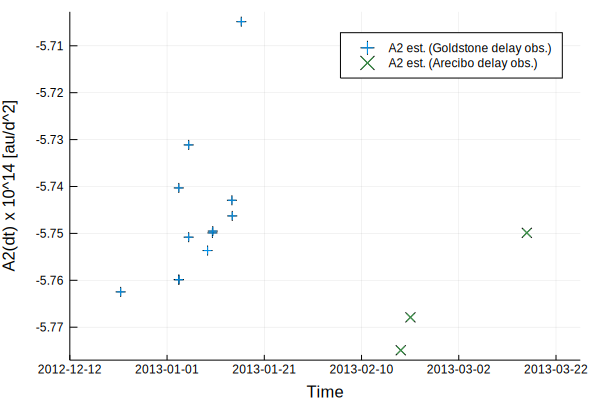

In [80]:
scatter(
    tv_jpl_utc_jul[delay_index][1:end-3].-t0,
    A2_del_v[1:end-3],
    marker=:cross,
    label="A2 est. (Goldstone delay obs.)"
)
scatter!(
    tv_jpl_utc_jul[delay_index][end-2:end].-t0,
    A2_del_v[end-2:end],
    marker=:xcross,
    label="A2 est. (Arecibo delay obs.)",
    color=3,
    leg=:topright
)
ylabel!("A2(dt) x 10^14 [au/d^2]")
xlims!(1540, 1645)
xticks!(1540:20:1645, string.(Date.(julian2datetime.(t0 .+ collect(1540:20:1640)))))
xlabel!("Time")

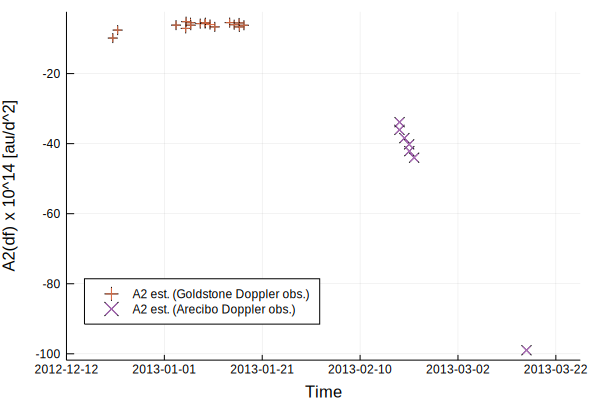

In [81]:
scatter(
    tv_jpl_utc_jul[doppler_index][1:end-7].-t0,
    A2_dop_v[1:end-7],
    marker=:cross,
    label="A2 est. (Goldstone Doppler obs.)",
    color=2
)
scatter!(
    tv_jpl_utc_jul[doppler_index][end-6:end].-t0,
    A2_dop_v[end-6:end],
    marker=:xcross,
    label="A2 est. (Arecibo Doppler obs.)",
    leg=:bottomleft,
    color=4
)
ylabel!("A2(df) x 10^14 [au/d^2]")
xlims!(1540, 1645)
xticks!(1540:20:1645, string.(Date.(julian2datetime.(t0 .+ collect(1540:20:1640)))))
xlabel!("Time")

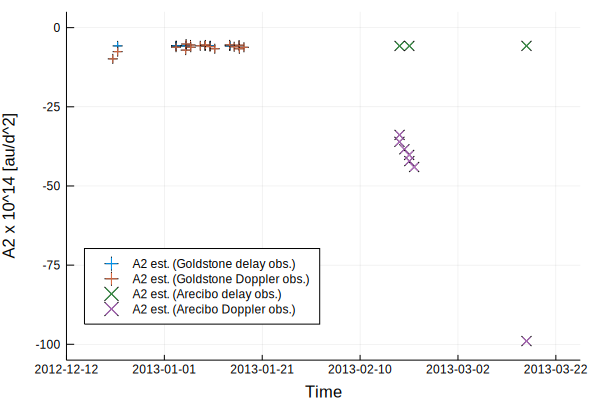

In [82]:
scatter(
    tv_jpl_utc_jul[delay_index][1:end-3].-t0,
    A2_del_v[1:end-3],
    marker=:cross,
    label="A2 est. (Goldstone delay obs.)"
)
scatter!(
    tv_jpl_utc_jul[doppler_index][1:end-7].-t0,
    A2_dop_v[1:end-7],
    marker=:cross,
    label="A2 est. (Goldstone Doppler obs.)"
)
scatter!(
    tv_jpl_utc_jul[delay_index][end-2:end].-t0,
    A2_del_v[end-2:end],
    marker=:xcross,
    label="A2 est. (Arecibo delay obs.)"
)
scatter!(
    tv_jpl_utc_jul[doppler_index][end-6:end].-t0,
    A2_dop_v[end-6:end],
    marker=:xcross,
    label="A2 est. (Arecibo Doppler obs.)",
    leg=:bottomleft
)
ylabel!("A2 x 10^14 [au/d^2]")
xlims!(1540, 1645)
ylims!(-105,5)
xticks!(1540:20:1645, string.(Date.(julian2datetime.(t0 .+ collect(1540:20:1640)))))
xlabel!("Time")

In [83]:
A2_NO_Arecibo_dop = vcat(A2_del_v, A2_dop_v[1:end-7]);

In [84]:
A2_mean_NO_Arecibo_dop = mean(A2_NO_Arecibo_dop)
A2_std_NO_Arecibo_dop = std(A2_NO_Arecibo_dop)
A2_mean_NO_Arecibo_dop, A2_std_NO_Arecibo_dop

(-6.038285780529757, 0.8501724040305515)

# Intervals

In [85]:
using IntervalArithmetic

In [86]:
residual_td_interval = interval.(
    (tdelay_jpl_obs-tdelay_jpl_obs_sigma)-tdelay_v1[delay_index](), 
    (tdelay_jpl_obs+tdelay_jpl_obs_sigma)-tdelay_v1[delay_index]()
);

In [87]:
residual_ds_interval = interval.(
    (dshift_jpl_obs-dshift_jpl_obs_sigma)-dshift_v1[doppler_index](),
    (dshift_jpl_obs+dshift_jpl_obs_sigma)-dshift_v1[doppler_index]()
);

In [88]:
A2_del_v_interval = map((x,y)->x(y), A2_δτ_v, residual_td_interval)

15-element Array{Interval{Float64},1}:
 [-5.77004, -5.7549] 
 [-5.76947, -5.75026]
 [-5.85563, -5.62498]
 [-5.7695, -5.75024] 
 [-5.76115, -5.74046]
 [-5.85528, -5.60698]
 [-5.7636, -5.74372] 
 [-5.76043, -5.73936]
 [-5.76009, -5.73892]
 [-5.75718, -5.72869]
 [-5.76062, -5.73193]
 [-5.79175, -5.61797]
 [-5.78515, -5.76469]
 [-5.77764, -5.75817]
 [-5.80596, -5.6938] 

In [89]:
A2_dop_v_interval = map((x,y)->x(y), A2_δν_v, residual_ds_interval)

24-element Array{Interval{Float64},1}:
  [-17.9768, -1.74214] 
  [-10.4247, -4.73918] 
   [-7.26342, -5.06307]
   [-9.09522, -5.10103]
   [-6.16936, -4.18496]
   [-6.42458, -4.51315]
   [-7.12624, -5.22778]
   [-6.61122, -4.85194]
   [-6.55233, -4.85591]
   [-6.30913, -4.62414]
   [-6.81056, -5.17183]
   [-8.26005, -5.06747]
   [-6.18611, -4.71303]
   [-6.77135, -5.30928]
   [-6.97965, -4.10144]
   [-7.38372, -5.95665]
   [-6.90878, -5.48564]
  [-46.5877, -25.5139] 
  [-44.4213, -23.3267] 
  [-49.3516, -27.4833] 
  [-51.5401, -28.861]  
  [-53.492, -30.7921]  
  [-55.7697, -32.2486] 
 [-126.782, -71.1924]  

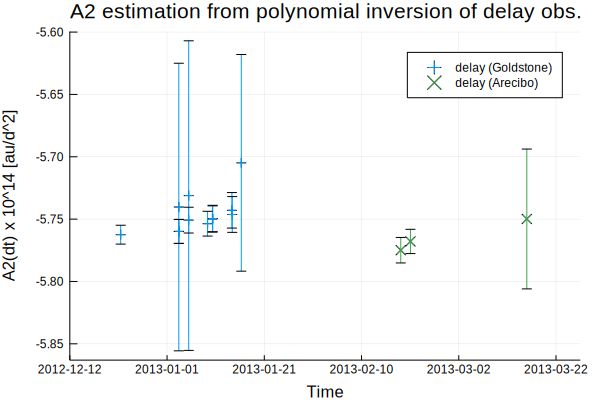

In [90]:
scatter(
    tv_jpl_utc_jul[delay_index][1:end-3].-t0,
    mid.(A2_del_v_interval[1:end-3]),
    yerror=radius.(A2_del_v_interval[1:end-3]),
    label="delay (Goldstone)",
    leg=:topright,
    marker=:cross
)
scatter!(
    tv_jpl_utc_jul[delay_index][end-2:end].-t0,
    mid.(A2_del_v_interval[end-2:end]),
    yerror=radius.(A2_del_v_interval[end-2:end]),
    label="delay (Arecibo)",
    leg=:topright,
    marker=:xcross,
    color=3
)
#ylims!(minimum(A2_del_v)-1,0)
ylabel!("A2(dt) x 10^14 [au/d^2]")
xlims!(1540, 1645)
xticks!(1540:20:1645, string.(Date.(julian2datetime.(t0 .+ collect(1540:20:1640)))))
xlabel!("Time")
title!("A2 estimation from polynomial inversion of delay obs.")
#savefig("A2_poly_inv_delay.pdf")

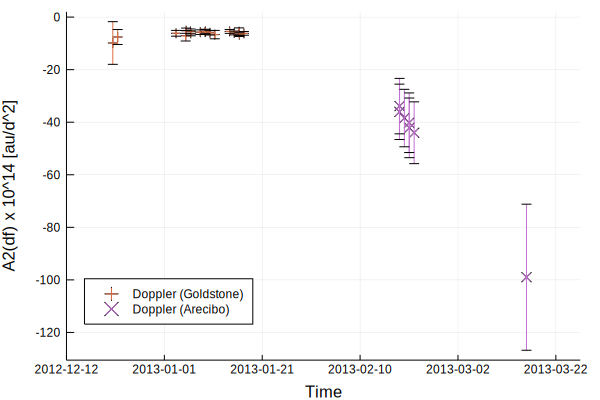

In [91]:
scatter(
    tv_jpl_utc_jul[doppler_index][1:end-7].-t0,
    mid.(A2_dop_v_interval[1:end-7]),
    yerror=radius.(A2_dop_v_interval[1:end-7]),
    label="Doppler (Goldstone)",
    marker=:cross,
    color=2
)
scatter!(
    tv_jpl_utc_jul[doppler_index][end-6:end].-t0,
    mid.(A2_dop_v_interval[end-6:end]),
    yerror=radius.(A2_dop_v_interval[end-6:end]),
    label="Doppler (Arecibo)",
    marker=:xcross,
    leg=:bottomleft,
    color=4
)
ylabel!("A2(df) x 10^14 [au/d^2]")
xlims!(1540, 1645)
xticks!(1540:20:1645, string.(Date.(julian2datetime.(t0 .+ collect(1540:20:1640)))))
xlabel!("Time")

In [92]:
A2_v_NO_Arecibo_dop_interval = vcat(A2_del_v_interval, A2_dop_v_interval[1:end-7])

32-element Array{Interval{Float64},1}:
 [-5.77004, -5.7549] 
 [-5.76947, -5.75026]
 [-5.85563, -5.62498]
 [-5.7695, -5.75024] 
 [-5.76115, -5.74046]
 [-5.85528, -5.60698]
 [-5.7636, -5.74372] 
 [-5.76043, -5.73936]
 [-5.76009, -5.73892]
 [-5.75718, -5.72869]
 [-5.76062, -5.73193]
 [-5.79175, -5.61797]
 [-5.78515, -5.76469]
   ⋮                 
 [-6.42458, -4.51315]
 [-7.12624, -5.22778]
 [-6.61122, -4.85194]
 [-6.55233, -4.85591]
 [-6.30913, -4.62414]
 [-6.81056, -5.17183]
 [-8.26005, -5.06747]
 [-6.18611, -4.71303]
 [-6.77135, -5.30928]
 [-6.97965, -4.10144]
 [-7.38372, -5.95665]
 [-6.90878, -5.48564]

In [93]:
A2_mean_NO_Arecibo_dop_interval = mean(A2_v_NO_Arecibo_dop_interval)
A2_std_NO_Arecibo_dop_interval = std(A2_v_NO_Arecibo_dop_interval)
A2_mean_NO_Arecibo_dop_interval, A2_std_NO_Arecibo_dop_interval

([-6.87489, -5.20168], [0, 3.08262])

## Least squares

In [94]:
res_del = tdelay_jpl_obs .- tdelay_v1[delay_index]
res_dop = dshift_jpl_obs .- dshift_v1[doppler_index]
res_deldop = vcat(res_del, res_dop)
res_sq_del = res_del.^2
res_sq_dop = res_dop.^2
res_sq_deldop = res_deldop.^2
res_sq_deldop_NO_Arecibo_dop = vcat(res_sq_del, res_sq_dop[1:end-7]); #remove Arecibo Doppler "outliers"

In [95]:
function taylor_minimum(pol::Taylor1{T}, x0::T; niters::Int=10) where {T<:Real}
    dpol = differentiate(pol)
    dpol2 = differentiate(dpol)
    xnewton::T = x0
    #@show xnewton
    for i in 1:niters
        xnewton -= dpol(xnewton)/dpol2(xnewton) 
        #@show xnewton, dpol(xnewton)
    end
    return xnewton
end

function taylor_roots(pol::Taylor1{T}, x0::T; niters::Int=10) where {T<:Real}
    dpol = differentiate(pol)
    xnewton::T = x0
    #@show xnewton
    for i in 1:niters
        xnewton -= pol(xnewton)/dpol(xnewton) 
        #@show xnewton, pol(xnewton)
    end
    return xnewton
end

taylor_roots (generic function with 1 method)

In [96]:
taylor_roots.(res_del, 0.0)

15-element Array{Float64,1}:
 -5.762470792515521
 -5.759860870468456
 -5.740304599074605
 -5.759868643791216
 -5.750805999985048
 -5.731132919296619
 -5.75365755853765 
 -5.749893504937906
 -5.749507821694208
 -5.74293781584091 
 -5.746273708482464
 -5.704856043300141
 -5.774919833611218
 -5.767903576253135
 -5.749879957982836

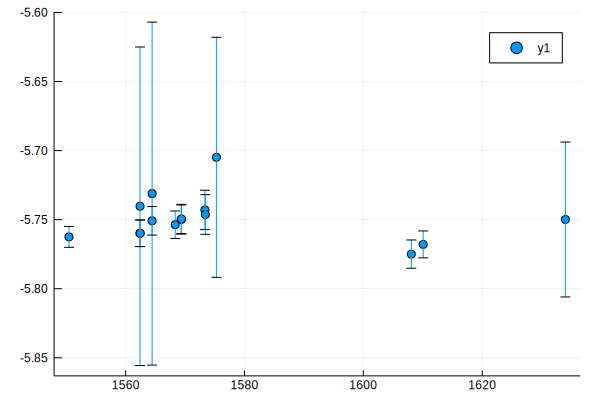

In [97]:
scatter(
    tv_jpl_utc_jul[delay_index].-t0,
    taylor_roots.(res_del, 0.0),
    yerror=radius.(A2_del_v_interval)
)

In [98]:
Q_A2_del = sum(res_sq_del)/length(res_sq_del)

 18688.252412219732 + 6496.278562358993 t + 564.5496287868755 t² - 0.0001236094731418358 t³ - 1.6966106418787784e-11 t⁴ + 2.2375210963891113e-18 t⁵ + 1.3648976108979408e-24 t⁶ + 2.6046855565469743e-31 t⁷ + 4.8261430831139936e-39 t⁸ - 1.237585184503296e-44 t⁹ - 3.9421569560016356e-51 t¹⁰ + 𝒪(t¹¹)

In [99]:
B_del = differentiate.(res_sq_del)
C_del = ( transpose(B_del) )*( B_del )
Γ_del = inv(C_del)

 1.2219769849993087e-9 - 4.246850938577416e-10 t + 1.106960511171577e-10 t² - 2.5647456806380628e-11 t³ + 5.570924842290164e-12 t⁴ - 1.1616653738595257e-12 t⁵ + 2.355048443392131e-13 t⁶ - 4.676956291240395e-14 t⁷ + 9.142960826341782e-15 t⁸ - 1.7652851985677623e-15 t⁹ + 3.374252662263803e-16 t¹⁰ + 𝒪(t¹¹)

In [100]:
Q_A2_dop = sum(res_sq_dop)/length(res_sq_dop)

 0.48742274655483914 + 0.11696611509007072 t + 0.009253281571516517 t² + 2.737433617064959e-9 t³ - 1.5981481719680313e-16 t⁴ - 3.7280996468470326e-22 t⁵ - 1.0396563135352202e-28 t⁶ + 3.481470584398571e-36 t⁷ + 1.026667950969476e-41 t⁸ + 2.840848797010035e-48 t⁹ + 2.192779556643065e-55 t¹⁰ + 𝒪(t¹¹)

In [101]:
B_dop = differentiate.(res_sq_dop)
C_dop = ( transpose(B_dop) )*( B_dop )
Γ_dop = inv(C_dop)

 2.0327491270925857 - 0.6701040285749195 t + 0.1649698539901722 t² - 0.03594459832033927 t³ + 0.007310024942666471 t⁴ - 0.0014207397324514058 t⁵ + 0.0002672124478126943 t⁶ - 4.8995081699930717e-5 t⁷ + 8.798902668276193e-6 t⁸ - 1.5524624811735133e-6 t⁹ + 2.696680584191618e-7 t¹⁰ + 𝒪(t¹¹)

In [102]:
Q_A2_deldop = sum(res_sq_deldop)/length(res_sq_deldop)

 7188.089341774699 + 2498.640656978131 t + 217.14016693745762 t² - 4.754042048001866e-5 t³ - 6.525523893267419e-12 t⁴ + 8.603556155560058e-19 t⁵ + 5.248966407260674e-25 t⁶ + 1.0018235615678175e-31 t⁷ + 1.8625268347421176e-39 t⁸ - 4.7581948026760556e-45 t⁹ - 1.5160792735663743e-51 t¹⁰ + 𝒪(t¹¹)

In [103]:
B_deldop = differentiate.(res_sq_deldop)
C_deldop = ( transpose(B_deldop) )*( B_deldop )
Γ_deldop = inv(C_deldop)

 1.221976984264723e-9 - 4.246850935893056e-10 t + 1.1069605104344979e-10 t² - 2.5647456788363994e-11 t³ + 5.570924838156959e-12 t⁴ - 1.161665372948531e-12 t⁵ + 2.35504844143899e-13 t⁶ - 4.676956287137266e-14 t⁷ + 9.142960817856098e-15 t⁸ - 1.7652851968346891e-15 t⁹ + 3.374252658760546e-16 t¹⁰ + 𝒪(t¹¹)

In [104]:
Q_A2_deldop_NO_Arecibo_dop = sum(res_sq_deldop_NO_Arecibo_dop)/length(res_sq_deldop_NO_Arecibo_dop)

 8760.368027700599 + 3045.2130757328523 t + 264.63951475151225 t² - 5.793986293665879e-5 t³ - 7.95298793575625e-12 t⁴ + 1.0485591395103386e-18 t⁵ + 6.397177967163777e-25 t⁶ + 1.2209720310419792e-31 t⁷ + 2.2699672960967724e-39 t⁸ - 5.799051742738788e-45 t⁹ - 1.84772147190293e-51 t¹⁰ + 𝒪(t¹¹)

In [105]:
A2_lsqfit_del = taylor_minimum(Q_A2_del, 0.0, niters=5)

-5.753494427859338

In [106]:
sqrt(Γ_del()), sqrt(Γ_del(A2_lsqfit_del))

(3.4956787395287185e-5, 0.00028378202635149504)

In [107]:
sqrt(Q_A2_del(1)-Q_A2_del())

84.02873358284283

In [108]:
A2_lsqfit_dop = taylor_minimum(Q_A2_dop, 0.0, niters=5)

-6.320268233116793

In [109]:
sqrt(Γ_dop()), sqrt(Γ_dop(A2_lsqfit_dop))

(1.4257451129471164, 12.629681237717067)

In [110]:
A2_lsqfit_deldop = taylor_minimum(Q_A2_deldop, 0.0, niters=5)

-5.7535092909130485

In [111]:
sqrt(Γ_deldop()), sqrt(Γ_deldop(A2_lsqfit_deldop))

(3.495678738478013e-5, 0.0002837844693058003)

In [112]:
A2_lsqfit_deldop_NO_Arecibo_dop = taylor_minimum(Q_A2_deldop_NO_Arecibo_dop, 0.0, niters=5)

-5.753500804080844

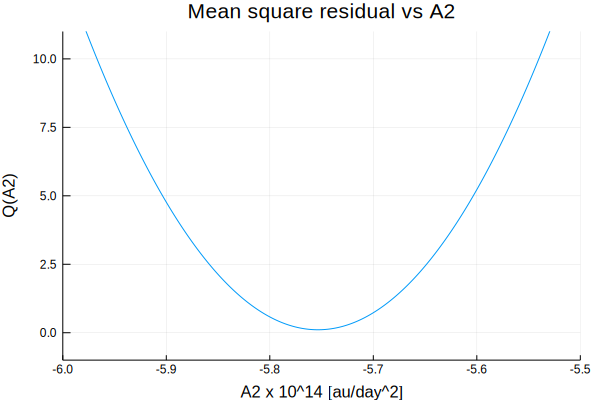

In [124]:
_A2_min_plot = -6.0
A2_vals = range(_A2_min_plot, length=2000, stop=-5.5)
plot(A2_vals, Q_A2_deldop.(A2_vals), leg=false)
xlabel!("A2 x 10^14 [au/day^2]")
ylabel!("Q(A2)")
title!("Mean square residual vs A2")
ylims!(-1, 11)
xlims!(_A2_min_plot, -5.5)

In [125]:
mean(res_deldop), std(res_deldop)

( 25.616678685578517 + 4.439221488424292 t - 1.4243130316623044e-6 t² - 2.646804411331328e-13 t³ - 3.3031812445080107e-20 t⁴ + 4.079239922743176e-27 t⁵ + 2.6979645234280204e-33 t⁶ + 5.410374284502935e-40 t⁷ + 1.6728847290720392e-47 t⁸ - 2.206619296083079e-53 t⁹ - 7.005221876673407e-60 t¹⁰ + 𝒪(t¹¹),  81.87653244542352 + 14.23468302932538 t + 1.814526905342804e-5 t² - 3.3733555729389178e-6 t³ + 5.864742690324906e-7 t⁴ - 1.0196101208429637e-7 t⁵ + 1.7726280211479354e-8 t⁶ - 3.081764017929829e-9 t⁷ + 5.357713019996986e-10 t⁸ - 9.314462787325225e-11 t⁹ + 1.6193266891370984e-11 t¹⁰ + 𝒪(t¹¹))

Compute the value of A2 such that the mean of the residuals is zero:

In [126]:
A2_zero_mean_res = taylor_roots(mean(res_deldop), A2_lsqfit_deldop)

-5.770523350617548

Check that the vector of residuals evaluated at the LS solution has mean zero:

In [127]:
mean(res_deldop()), std(res_deldop()) #A2 = 0

(25.616678685578517, 81.8765324454235)

In [128]:
# A2 = A2 LS solution
mean(res_deldop(A2_lsqfit_deldop)), std(res_deldop(A2_lsqfit_deldop))

(0.07552945871099116, 0.325119834116548)

In [129]:
# A2 such that res. mean is closest to zero
mean(res_deldop(A2_zero_mean_res)), std(res_deldop(A2_zero_mean_res))

(1.1617487598705804e-14, 0.41960632125667546)

If we expand the "cost" function Q wrt the solution value, then the first-order term should be zero:

In [130]:
ΔQ = Q_A2_del(A2_lsqfit_del+Taylor1(Q_A2_del.order))-Q_A2_del(A2_lsqfit_del)

 564.5517623427506 t² - 0.00012360908268350016 t³ - 1.6966170785935862e-11 t⁴ + 2.237473978985384e-18 t⁵ + 1.364887120671729e-24 t⁶ + 2.6046833350245054e-31 t⁷ + 4.826783916793346e-39 t⁸ - 1.2375625033252168e-44 t⁹ - 3.9421569560016356e-51 t¹⁰ + 𝒪(t¹¹)

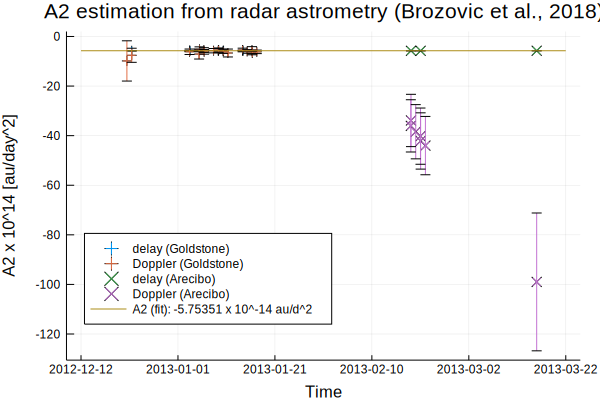

In [131]:
scatter(
    tv_jpl_utc_jul[delay_index][1:end-3].-t0,
    mid.(A2_del_v_interval[1:end-3]),
    yerror=radius.(A2_del_v_interval[1:end-3]),
    marker=:cross,
    leg=:bottomleft,
    label="delay (Goldstone)"
)
scatter!(
    tv_jpl_utc_jul[doppler_index][1:end-7].-t0,
    mid.(A2_dop_v_interval[1:end-7]),
    yerror=radius.(A2_dop_v_interval[1:end-7]),
    marker=:cross,
    label="Doppler (Goldstone)"
)
scatter!(
    tv_jpl_utc_jul[delay_index][end-2:end].-t0,
    mid.(A2_del_v_interval[end-2:end]),
    yerror=radius.(A2_del_v_interval[end-2:end]),
    marker=:xcross,
    leg=:bottomleft,
    label="delay (Arecibo)"
)
scatter!(
    tv_jpl_utc_jul[doppler_index][end-6:end].-t0,
    mid.(A2_dop_v_interval[end-6:end]),
    yerror=radius.(A2_dop_v_interval[end-6:end]),
    marker=:xcross,
    label="Doppler (Arecibo)"
)
A2_label_str = @sprintf "A2 (fit): %.5f  x 10^-14 au/d^2" A2_lsqfit_deldop
plot!([1540, 1640], [A2_lsqfit_deldop, A2_lsqfit_deldop], label=A2_label_str)
ylabel!("A2 x 10^14 [au/day^2]")
xticks!(1540:20:1640, string.(Date.(julian2datetime.(t0 .+ collect(1540:20:1640)))))
xlabel!("Time")
title!("A2 estimation from radar astrometry (Brozovic et al., 2018)")
#savefig("A2_fit_all.pdf")

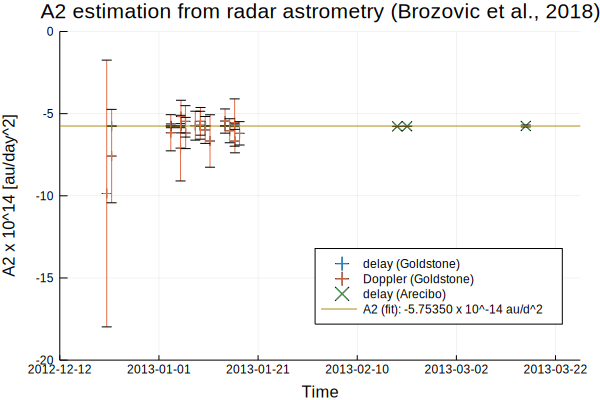

In [132]:
scatter(
    tv_jpl_utc_jul[delay_index][1:end-3].-t0,
    mid.(A2_del_v_interval[1:end-3]),
    yerror=radius.(A2_del_v_interval[1:end-3]),
    marker=:cross,
    leg=:bottomleft,
    label="delay (Goldstone)"
)
scatter!(
    tv_jpl_utc_jul[doppler_index][1:end-7].-t0,
    mid.(A2_dop_v_interval[1:end-7]),
    yerror=radius.(A2_dop_v_interval[1:end-7]),
    marker=:cross,
    label="Doppler (Goldstone)"
)
scatter!(
    tv_jpl_utc_jul[delay_index][end-2:end].-t0,
    mid.(A2_del_v_interval[end-2:end]),
    yerror=radius.(A2_del_v_interval[end-2:end]),
    marker=:xcross,
    leg=:bottomright,
    label="delay (Arecibo)"
)
scatter!(
    tv_jpl_utc_jul[doppler_index][end-6:end].-t0,
    mid.(A2_dop_v_interval[end-6:end]),
    yerror=radius.(A2_dop_v_interval[end-6:end]),
    marker=:xcross,
    label=""#"Doppler (Arecibo)"
)
A2_label_str = @sprintf "A2 (fit): %.5f  x 10^-14 au/d^2" A2_lsqfit_deldop_NO_Arecibo_dop
plot!([1540, 1645], [A2_lsqfit_deldop, A2_lsqfit_deldop], label=A2_label_str)
ylims!(-20,0)
ylabel!("A2 x 10^14 [au/day^2]")
xlims!(1540, 1645)
xlabel!("Time")
xticks!(1540:20:1645, string.(Date.(julian2datetime.(t0 .+ collect(1540:20:1645)))))
title!("A2 estimation from radar astrometry (Brozovic et al., 2018)")
#savefig("A2_fit_no_Arecibo_doppler.pdf")

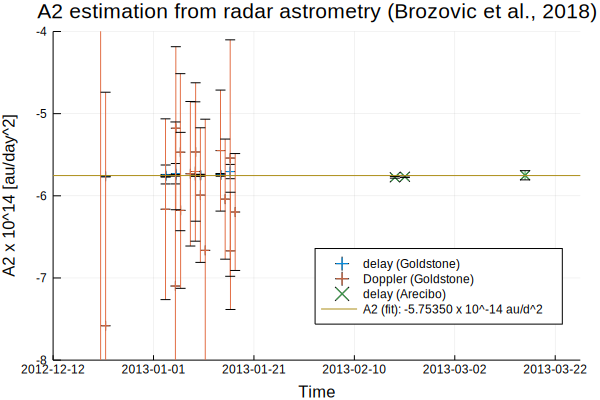

In [133]:
scatter(
    tv_jpl_utc_jul[delay_index][1:end-3].-t0,
    mid.(A2_del_v_interval[1:end-3]),
    yerror=radius.(A2_del_v_interval[1:end-3]),
    marker=:cross,
    leg=:bottomleft,
    label="delay (Goldstone)"
)
scatter!(
    tv_jpl_utc_jul[doppler_index][1:end-7].-t0,
    mid.(A2_dop_v_interval[1:end-7]),
    yerror=radius.(A2_dop_v_interval[1:end-7]),
    marker=:cross,
    label="Doppler (Goldstone)"
)
scatter!(
    tv_jpl_utc_jul[delay_index][end-2:end].-t0,
    mid.(A2_del_v_interval[end-2:end]),
    yerror=radius.(A2_del_v_interval[end-2:end]),
    marker=:xcross,
    leg=:bottomright,
    label="delay (Arecibo)"
)
scatter!(
    tv_jpl_utc_jul[doppler_index][end-6:end].-t0,
    mid.(A2_dop_v_interval[end-6:end]),
    yerror=radius.(A2_dop_v_interval[end-6:end]),
    marker=:xcross,
    label=""#"Doppler (Arecibo)"
)
A2_label_str = @sprintf "A2 (fit): %.5f  x 10^-14 au/d^2" A2_lsqfit_deldop_NO_Arecibo_dop
plot!([1540, 1645], [A2_lsqfit_deldop, A2_lsqfit_deldop], label=A2_label_str)
ylims!(-8,-4)
ylabel!("A2 x 10^14 [au/day^2]")
xlims!(1540, 1645)
xlabel!("Time")
xticks!(1540:20:1645, string.(Date.(julian2datetime.(t0 .+ collect(1540:20:1645)))))
title!("A2 estimation from radar astrometry (Brozovic et al., 2018)")
#savefig("A2_fit_no_Arecibo_doppler.pdf")

- Compare directly ephemerides JPL vs TaylorIntegration
- Propagate A2 interval trough March 2021 approach to see what difference in us, hz expect from A2 not zero

## Ephemerides: DE430+s199 vs TaylorIntegration

In [134]:
tv_et = Array{Float64}(undef, length(tv))
apophis_jpl = Array{Float64}(undef, length(tv), 6)
earth_jpl = Array{Float64}(undef, length(tv), 6)
for i in eachindex(tv)
    tv_et[i] = julian2etsecs(tv[i])
    apophis_jpl[i,:] .= Apophis.apophis_pv(tv_et[i])
    earth_jpl[i,:] .= Apophis.earth_pv(tv_et[i])
end

In [172]:
A2_lsqfit_deldop = -5.753494427859338
apophis_ti = [apophis(tv[i])[j](A2_lsqfit_deldop) for i in eachindex(tv), j in 1:6];
earth_ti = [ss16asteph(tv[i])[j] for i in eachindex(tv), j in union(3*4-2:3*4,3*(27+4)-2:3*(27+4))];

In [173]:
1000*au*(apophis_ti - apophis_jpl) 

30×6 Array{Float64,2}:
  -1.66087e-5   1.66087e-5  -4.15218e-6  …  -1.55707e-6  -1.29755e-7
 -33.3134      43.1362      15.1653         -0.284085    -0.0289008 
 -32.2674      42.8483      15.1408         -0.252775    -0.0174162 
 -22.4046      41.7313      15.618           0.058404     0.0927308 
 -22.3825      41.7329      15.6206          0.0590704    0.0929581 
 -22.3549      41.735       15.6238      …   0.0599028    0.0932422 
 -21.0128      41.8672      15.8029          0.102347     0.107574  
 -20.9474      41.8757      15.8118          0.104285     0.108226  
 -20.942       41.8765      15.8126          0.104446     0.108281  
 -20.6624      41.9081      15.8755          0.118481     0.112819  
 -20.6245      41.9139      15.881       …   0.119596     0.113193  
 -19.1243      42.1891      16.1152          0.163375     0.127757  
 -18.7857      42.2707      16.201           0.178654     0.132581  
   ⋮                                     ⋱                ⋮         
 -15.4354  

In [174]:
1000au*(earth_ti - earth_jpl)

30×6 Array{Float64,2}:
   0.00126226    0.00658483   -4.93071e-5  …   0.00046712  -0.000224088
 -17.0136        5.72635      12.2468          0.385076    -3.79268    
 -18.8746        5.96066       8.30621         0.0868967   -4.11152    
 -13.8809      -12.0204      -13.2926         -1.96178      2.7153     
 -13.81        -12.0747      -13.2169         -1.95207      2.73746    
 -13.7211      -12.1423      -13.1213      …  -1.93975      2.76505    
  -8.39963     -14.9752       -6.52344        -0.987039     4.0326     
  -8.17389     -15.0553       -6.18567        -0.934653     4.07377    
  -8.1551      -15.0617       -6.15736        -0.930253     4.07713    
  -6.04944     -15.6949       -2.3652         -0.329421     4.42037    
  -5.92684     -15.71         -2.15        …  -0.294909     4.43365    
  -1.88001     -14.9225        6.63997         1.08811      4.42399    
  -0.392846    -13.4278       10.8844          1.67613      3.97736    
   ⋮                                     

In [175]:
x_ae_ti = apophis_ti - earth_ti;

In [176]:
x_ae_jpl = apophis_jpl - earth_jpl;

In [177]:
r(x,y,z) = sqrt(x^2 + y^2 + z^2)
vr(x,y,z,u,v,w) = (x*u + y*v + z*w)/r(x,y,z)

r_ae_ti = r.(x_ae_ti[:,1], x_ae_ti[:,2], x_ae_ti[:,3])
vr_ae_ti = vr.( x_ae_ti[:,1], x_ae_ti[:,2], x_ae_ti[:,3], x_ae_ti[:,4], x_ae_ti[:,5], x_ae_ti[:,6] )

r_ae_jpl = r.(x_ae_jpl[:,1], x_ae_jpl[:,2], x_ae_jpl[:,3])
vr_ae_jpl = vr.( x_ae_jpl[:,1], x_ae_jpl[:,2], x_ae_jpl[:,3], x_ae_jpl[:,4], x_ae_jpl[:,5], x_ae_jpl[:,6] );

In [178]:
tve = range(tv[1], tv[end], length=2000)

2.4547335e6:0.8174087459560653:2.456367500083166e6

In [179]:
julian2datetime.(tve)

2000-element Array{DateTime,1}:
 2008-09-24T00:00:00    
 2008-09-24T19:37:04.116
 2008-09-25T15:14:08.231
 2008-09-26T10:51:12.347
 2008-09-27T06:28:16.463
 2008-09-28T02:05:20.578
 2008-09-28T21:42:24.694
 2008-09-29T17:19:28.81 
 2008-09-30T12:56:32.925
 2008-10-01T08:33:37.041
 2008-10-02T04:10:41.157
 2008-10-02T23:47:45.272
 2008-10-03T19:24:49.388
 ⋮                      
 2013-03-07T00:12:21.913
 2013-03-07T19:49:26.029
 2013-03-08T15:26:30.145
 2013-03-09T11:03:34.26 
 2013-03-10T06:40:38.376
 2013-03-11T02:17:42.492
 2013-03-11T21:54:46.607
 2013-03-12T17:31:50.723
 2013-03-13T13:08:54.839
 2013-03-14T08:45:58.954
 2013-03-15T04:23:03.07 
 2013-03-16T00:00:07.186

In [180]:
earth_ti_e = [ss16asteph(tve[i])[j] for i in eachindex(tve), j in union(3*4-2:3*4,3*(27+4)-2:3*(27+4))]
earth_jpl_e = Array{Float64}(undef, length(tve), 6)
moon_ti_e = [ss16asteph(tve[i])[j] for i in eachindex(tve), j in union(3*5-2:3*5,3*(27+5)-2:3*(27+5))]
moon_jpl_e = Array{Float64}(undef, length(tve), 6)
sun_ti_e = [ss16asteph(tve[i])[j] for i in eachindex(tve), j in union(3*1-2:3*1,3*(27+1)-2:3*(27+1))]
sun_jpl_e = Array{Float64}(undef, length(tve), 6)
jupiter_ti_e = [ss16asteph(tve[i])[j] for i in eachindex(tve), j in union(3*7-2:3*7,3*(27+7)-2:3*(27+7))]
jupiter_jpl_e = Array{Float64}(undef, length(tve), 6)
mercury_ti_e = [ss16asteph(tve[i])[j] for i in eachindex(tve), j in union(3*2-2:3*2,3*(27+2)-2:3*(27+2))]
mercury_jpl_e = Array{Float64}(undef, length(tve), 6)
venus_ti_e = [ss16asteph(tve[i])[j] for i in eachindex(tve), j in union(3*3-2:3*3,3*(27+3)-2:3*(27+3))]
venus_jpl_e = Array{Float64}(undef, length(tve), 6)
mars_ti_e = [ss16asteph(tve[i])[j] for i in eachindex(tve), j in union(3*6-2:3*6,3*(27+6)-2:3*(27+6))]
mars_jpl_e = Array{Float64}(undef, length(tve), 6)
apophis_ti_e = [apophis(tve[i])[j](-5.754) for i in eachindex(tve), j in 1:6];
apophis_jpl_e = Array{Float64}(undef, length(tve), 6)
for i in eachindex(tve)
    tve_et_i = julian2etsecs(tve[i])
    earth_jpl_e[i,:] .= Apophis.earth_pv(tve_et_i)
    moon_jpl_e[i,:] .= Apophis.moon_pv(tve_et_i)
    sun_jpl_e[i,:] .= Apophis.sun_pv(tve_et_i)
    jupiter_jpl_e[i,:] .= Apophis.kmsec2auday( Apophis.getpv(5, 0, tve_et_i) )
    mercury_jpl_e[i,:] .= Apophis.kmsec2auday( Apophis.getpv(1, 0, tve_et_i) )
    venus_jpl_e[i,:] .= Apophis.kmsec2auday( Apophis.getpv(2, 0, tve_et_i) )
    mars_jpl_e[i,:] .= Apophis.kmsec2auday( Apophis.getpv(4, 0, tve_et_i) )
    apophis_jpl_e[i,:] .= Apophis.apophis_pv(tve_et_i)
end

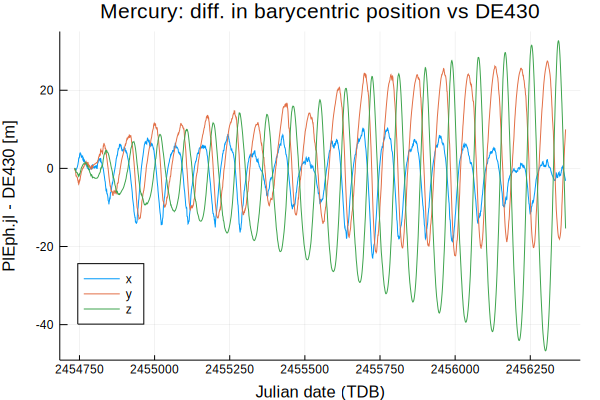

In [181]:
plot( tve, 1000au*(mercury_ti_e .- mercury_jpl_e)[:,1], label="x")#, marker=:cross)
plot!(tve, 1000au*(mercury_ti_e .- mercury_jpl_e)[:,2], label="y")#, marker=:cross)
plot!(tve, 1000au*(mercury_ti_e .- mercury_jpl_e)[:,3], label="z", leg=:bottomleft)#, marker=:cross)
title!("Mercury: diff. in barycentric position vs DE430")
ylabel!("PlEph.jl - DE430 [m]")
xlabel!("Julian date (TDB)")

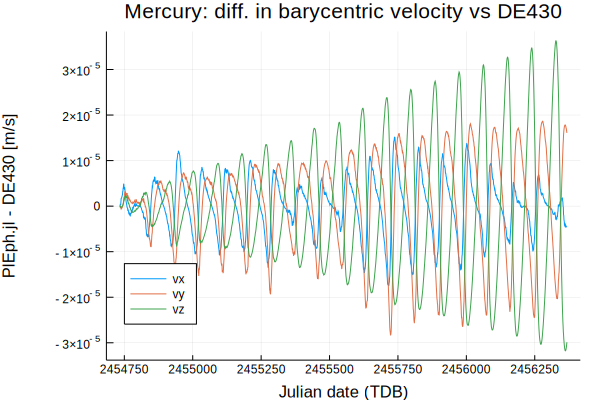

In [182]:
plot( tve, (1000/86400)*au*(mercury_ti_e .- mercury_jpl_e)[:,4], label="vx") #, marker=:cross)
plot!(tve, (1000/86400)*au*(mercury_ti_e .- mercury_jpl_e)[:,5], label="vy") #, marker=:cross)
plot!(tve, (1000/86400)*au*(mercury_ti_e .- mercury_jpl_e)[:,6], label="vz", leg=:bottomleft) #, marker=:cross)
title!("Mercury: diff. in barycentric velocity vs DE430")
ylabel!("PlEph.jl - DE430 [m/s]")
xlabel!("Julian date (TDB)")

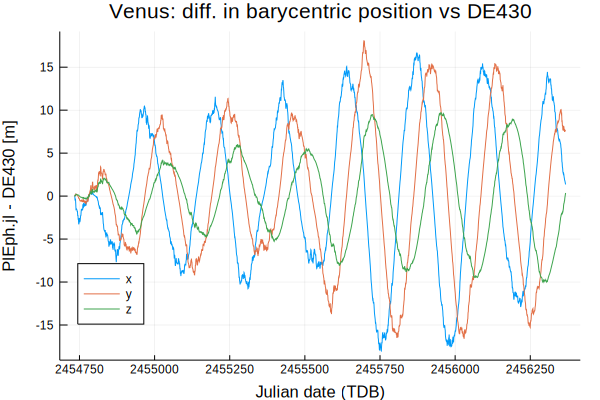

In [148]:
plot( tve, 1000au*(venus_ti_e .- venus_jpl_e)[:,1], label="x")#, marker=:cross)
plot!(tve, 1000au*(venus_ti_e .- venus_jpl_e)[:,2], label="y")#, marker=:cross)
plot!(tve, 1000au*(venus_ti_e .- venus_jpl_e)[:,3], label="z", leg=:bottomleft)#, marker=:cross)
title!("Venus: diff. in barycentric position vs DE430")
ylabel!("PlEph.jl - DE430 [m]")
xlabel!("Julian date (TDB)")

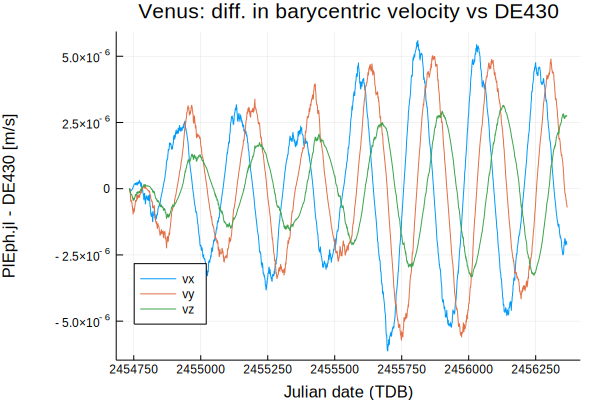

In [149]:
plot( tve, (1000/86400)*au*(venus_ti_e .- venus_jpl_e)[:,4], label="vx") #, marker=:cross)
plot!(tve, (1000/86400)*au*(venus_ti_e .- venus_jpl_e)[:,5], label="vy") #, marker=:cross)
plot!(tve, (1000/86400)*au*(venus_ti_e .- venus_jpl_e)[:,6], label="vz", leg=:bottomleft) #, marker=:cross)
title!("Venus: diff. in barycentric velocity vs DE430")
ylabel!("PlEph.jl - DE430 [m/s]")
xlabel!("Julian date (TDB)")

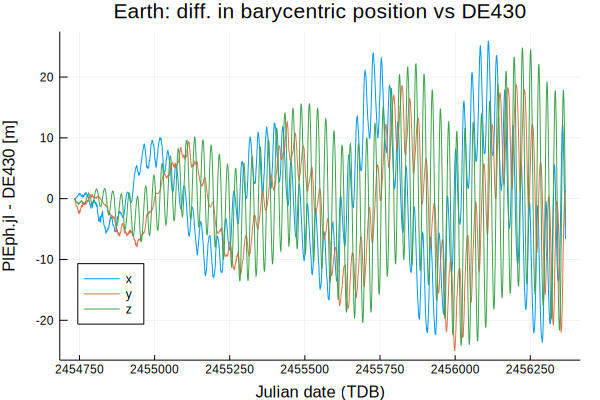

In [150]:
plot(tve, 1000au*(earth_ti_e .- earth_jpl_e)[:,1], label="x")#, marker=:cross)
plot!(tve, 1000au*(earth_ti_e .- earth_jpl_e)[:,2], label="y")#, marker=:cross)
plot!(tve, 1000au*(earth_ti_e .- earth_jpl_e)[:,3], label="z", leg=:bottomleft)#, marker=:cross)
title!("Earth: diff. in barycentric position vs DE430")
ylabel!("PlEph.jl - DE430 [m]")
xlabel!("Julian date (TDB)")

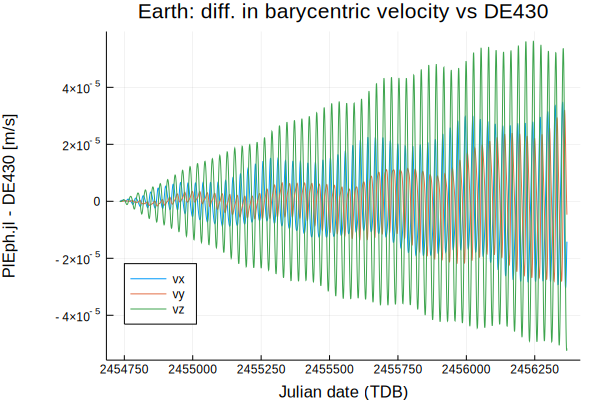

In [151]:
plot( tve, (1000/86400)*au*(earth_ti_e .- earth_jpl_e)[:,4], label="vx") #, marker=:cross)
plot!(tve, (1000/86400)*au*(earth_ti_e .- earth_jpl_e)[:,5], label="vy") #, marker=:cross)
plot!(tve, (1000/86400)*au*(earth_ti_e .- earth_jpl_e)[:,6], label="vz", leg=:bottomleft) #, marker=:cross)
title!("Earth: diff. in barycentric velocity vs DE430")
ylabel!("PlEph.jl - DE430 [m/s]")
xlabel!("Julian date (TDB)")

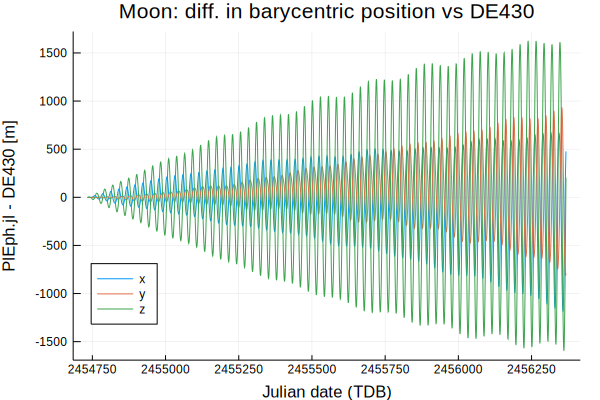

In [152]:
plot( tve, 1000au*(moon_ti_e .- moon_jpl_e)[:,1], label="x")#, marker=:cross)
plot!(tve, 1000au*(moon_ti_e .- moon_jpl_e)[:,2], label="y")#, marker=:cross)
plot!(tve, 1000au*(moon_ti_e .- moon_jpl_e)[:,3], label="z", leg=:bottomleft)#, marker=:cross)
title!("Moon: diff. in barycentric position vs DE430")
ylabel!("PlEph.jl - DE430 [m]")
xlabel!("Julian date (TDB)")

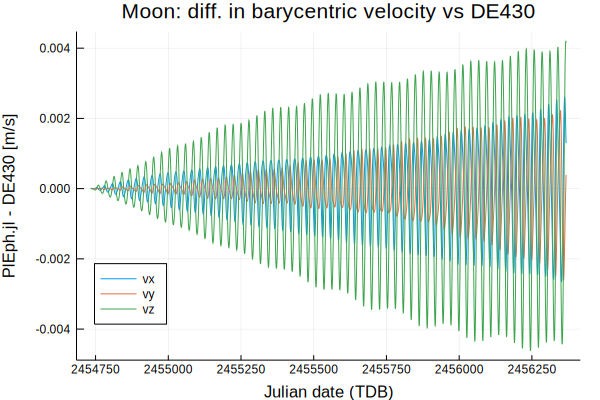

In [153]:
plot( tve, (1000/86400)*au*(moon_ti_e .- moon_jpl_e)[:,4], label="vx") #, marker=:cross)
plot!(tve, (1000/86400)*au*(moon_ti_e .- moon_jpl_e)[:,5], label="vy") #, marker=:cross)
plot!(tve, (1000/86400)*au*(moon_ti_e .- moon_jpl_e)[:,6], label="vz", leg=:bottomleft) #, marker=:cross)
title!("Moon: diff. in barycentric velocity vs DE430")
ylabel!("PlEph.jl - DE430 [m/s]")
xlabel!("Julian date (TDB)")

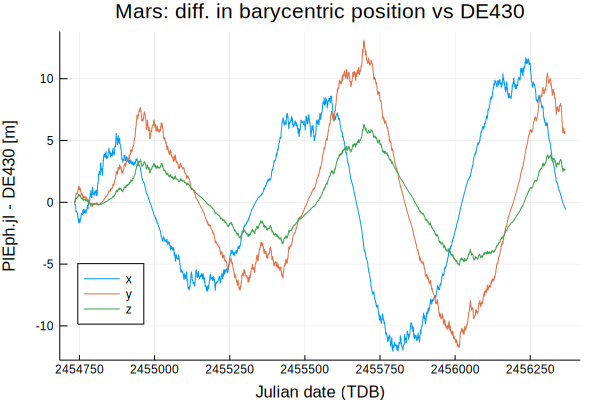

In [154]:
plot( tve, 1000au*(mars_ti_e .- mars_jpl_e)[:,1], label="x")#, marker=:cross)
plot!(tve, 1000au*(mars_ti_e .- mars_jpl_e)[:,2], label="y")#, marker=:cross)
plot!(tve, 1000au*(mars_ti_e .- mars_jpl_e)[:,3], label="z", leg=:bottomleft)#, marker=:cross)
title!("Mars: diff. in barycentric position vs DE430")
ylabel!("PlEph.jl - DE430 [m]")
xlabel!("Julian date (TDB)")

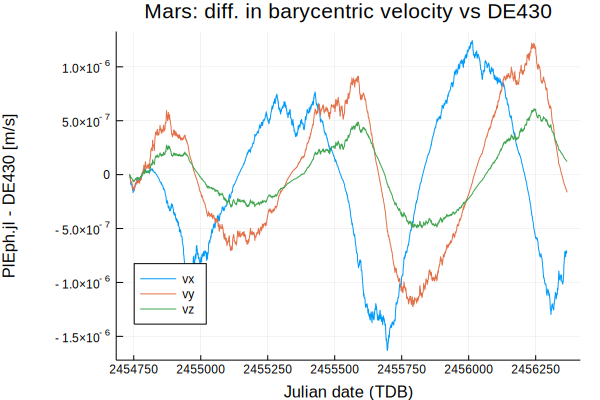

In [155]:
plot( tve, (1000/86400)*au*(mars_ti_e .- mars_jpl_e)[:,4], label="vx") #, marker=:cross)
plot!(tve, (1000/86400)*au*(mars_ti_e .- mars_jpl_e)[:,5], label="vy") #, marker=:cross)
plot!(tve, (1000/86400)*au*(mars_ti_e .- mars_jpl_e)[:,6], label="vz", leg=:bottomleft) #, marker=:cross)
title!("Mars: diff. in barycentric velocity vs DE430")
ylabel!("PlEph.jl - DE430 [m/s]")
xlabel!("Julian date (TDB)")

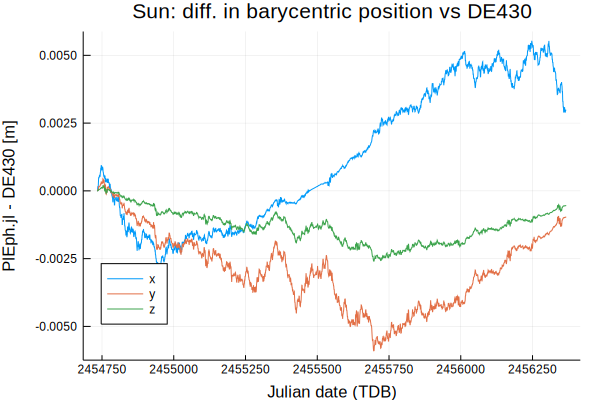

In [156]:
plot( tve, 1000au*(sun_ti_e .- sun_jpl_e)[:,1], label="x")#, marker=:cross)
plot!(tve, 1000au*(sun_ti_e .- sun_jpl_e)[:,2], label="y")#, marker=:cross)
plot!(tve, 1000au*(sun_ti_e .- sun_jpl_e)[:,3], label="z", leg=:bottomleft)#, marker=:cross)
title!("Sun: diff. in barycentric position vs DE430")
ylabel!("PlEph.jl - DE430 [m]")
xlabel!("Julian date (TDB)")

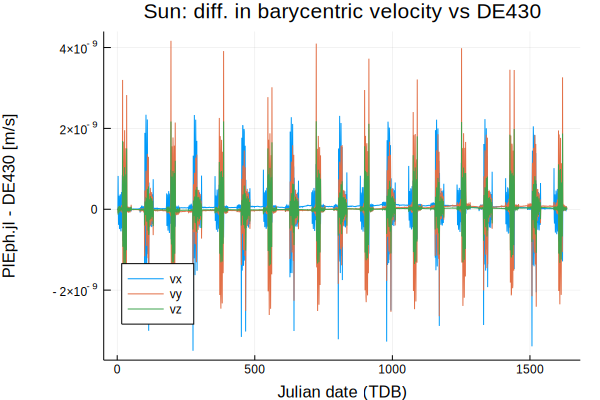

In [157]:
plot( tve.-t0, (1000/86400)*au*(sun_ti_e .- sun_jpl_e)[:,4], label="vx") #, marker=:cross)
plot!(tve.-t0, (1000/86400)*au*(sun_ti_e .- sun_jpl_e)[:,5], label="vy") #, marker=:cross)
plot!(tve.-t0, (1000/86400)*au*(sun_ti_e .- sun_jpl_e)[:,6], label="vz", leg=:bottomleft) #, marker=:cross)
title!("Sun: diff. in barycentric velocity vs DE430")
ylabel!("PlEph.jl - DE430 [m/s]")
xlabel!("Julian date (TDB)")

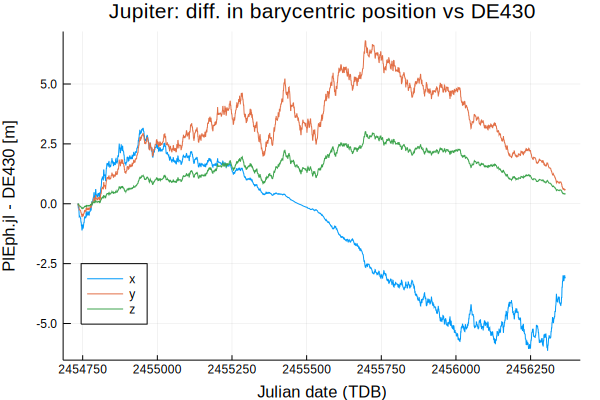

In [158]:
plot( tve, 1000au*(jupiter_ti_e .- jupiter_jpl_e)[:,1], label="x")#, marker=:cross)
plot!(tve, 1000au*(jupiter_ti_e .- jupiter_jpl_e)[:,2], label="y")#, marker=:cross)
plot!(tve, 1000au*(jupiter_ti_e .- jupiter_jpl_e)[:,3], label="z", leg=:bottomleft)#, marker=:cross)
title!("Jupiter: diff. in barycentric position vs DE430")
ylabel!("PlEph.jl - DE430 [m]")
xlabel!("Julian date (TDB)")

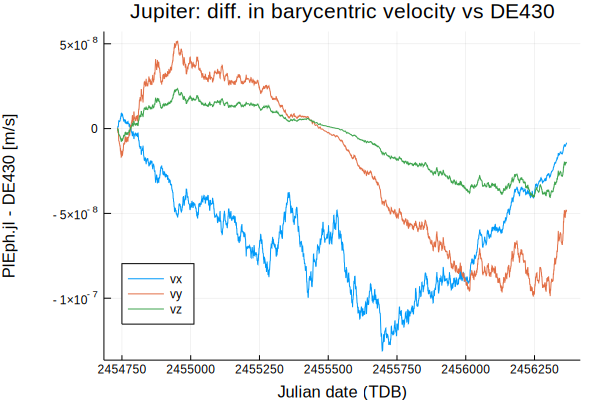

In [159]:
plot( tve, (1000/86400)*au*(jupiter_ti_e .- jupiter_jpl_e)[:,4], label="vx") #, marker=:cross)
plot!(tve, (1000/86400)*au*(jupiter_ti_e .- jupiter_jpl_e)[:,5], label="vy") #, marker=:cross)
plot!(tve, (1000/86400)*au*(jupiter_ti_e .- jupiter_jpl_e)[:,6], label="vz", leg=:bottomleft) #, marker=:cross)
title!("Jupiter: diff. in barycentric velocity vs DE430")
ylabel!("PlEph.jl - DE430 [m/s]")
xlabel!("Julian date (TDB)")

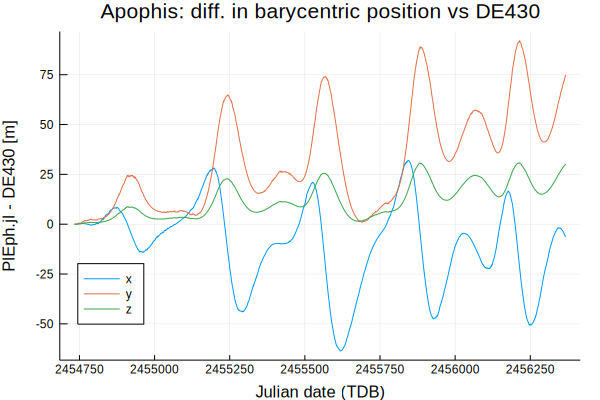

In [183]:
plot( tve, 1000au*(apophis_ti_e .- apophis_jpl_e)[:,1], label="x")#, marker=:cross)
plot!(tve, 1000au*(apophis_ti_e .- apophis_jpl_e)[:,2], label="y")#, marker=:cross)
plot!(tve, 1000au*(apophis_ti_e .- apophis_jpl_e)[:,3], label="z", leg=:bottomleft)#, marker=:cross)
title!("Apophis: diff. in barycentric position vs DE430")
ylabel!("PlEph.jl - DE430 [m]")
xlabel!("Julian date (TDB)")

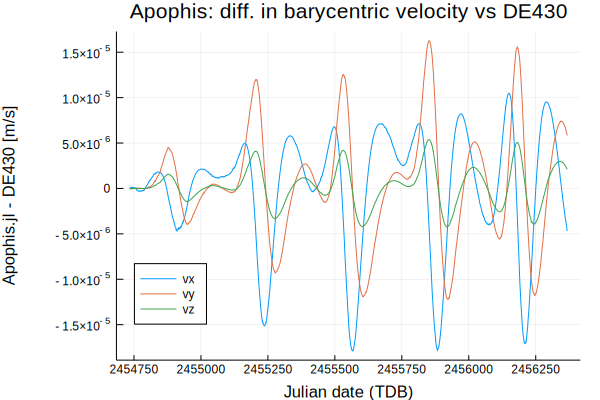

In [184]:
plot( tve, (1000/86400)*au*(apophis_ti_e .- apophis_jpl_e)[:,4], label="vx") #, marker=:cross)
plot!(tve, (1000/86400)*au*(apophis_ti_e .- apophis_jpl_e)[:,5], label="vy") #, marker=:cross)
plot!(tve, (1000/86400)*au*(apophis_ti_e .- apophis_jpl_e)[:,6], label="vz", leg=:bottomleft) #, marker=:cross)
title!("Apophis: diff. in barycentric velocity vs DE430")
ylabel!("Apophis.jl - DE430 [m/s]")
xlabel!("Julian date (TDB)")

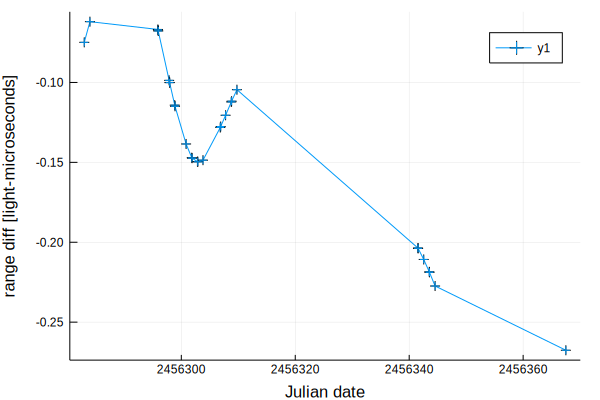

In [185]:
plot(tv[2:end], 1e6*86400(r_ae_jpl[2:end]-r_ae_ti[2:end])/c_au_per_day, m=:cross)
ylabel!("range diff [light-microseconds]")
xlabel!("Julian date")

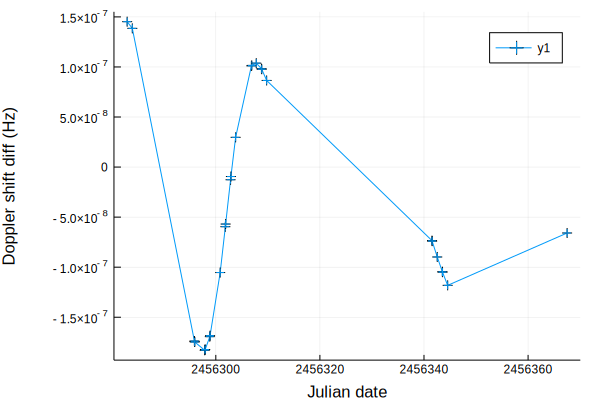

In [186]:
plot(tv[2:end], 1e6(vr_ae_jpl[2:end]-vr_ae_ti[2:end])/c_au_per_day, m=:cross)
ylabel!("Doppler shift diff (Hz)")
xlabel!("Julian date")

In [187]:
(x_ae_ti - x_ae_jpl)./x_ae_jpl

30×6 Array{Float64,2}:
  4.40766e-15  -9.0268e-14   1.9685e-15   …   1.12885e-13  -1.30332e-13
  1.24282e-9    9.07095e-9  -4.11412e-10     -2.8812e-9     1.60862e-7 
  1.03313e-9    8.47039e-9  -9.66819e-10     -1.46076e-9    1.565e-7   
  7.82555e-10   7.43648e-9  -4.43131e-9       7.92741e-9   -3.8762e-8  
  7.87416e-10   7.43694e-9  -4.42137e-9       7.88907e-9   -3.9021e-8  
  7.93521e-10   7.43747e-9  -4.40881e-9   …   7.84051e-9   -3.93418e-8 
  1.19943e-9    7.34648e-9  -3.49794e-9       4.16219e-9   -5.1745e-8  
  1.21653e-9    7.33724e-9  -3.44985e-9       3.96474e-9   -5.20368e-8 
  1.21796e-9    7.33645e-9  -3.44581e-9       3.94818e-9   -5.20601e-8 
  1.4152e-9     7.2028e-9   -2.89267e-9       1.68706e-9   -5.37984e-8 
  1.4247e-9     7.19381e-9  -2.86118e-9   …   1.56014e-9   -5.38187e-8 
  1.73516e-9    6.69187e-9  -1.54381e-9      -3.37915e-9   -4.83851e-8 
  1.88759e-9    6.32337e-9  -8.79192e-10     -5.38711e-9   -4.12429e-8 
  ⋮                                      

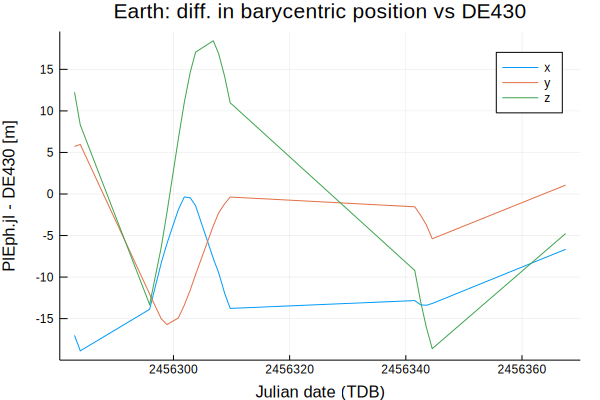

In [188]:
plot( tv[2:end], 1000au*(earth_ti .- earth_jpl)[2:end,1], label="x")#, marker=:cross)
plot!(tv[2:end], 1000au*(earth_ti .- earth_jpl)[2:end,2], label="y")#, marker=:cross)
plot!(tv[2:end], 1000au*(earth_ti .- earth_jpl)[2:end,3], label="z")#, marker=:cross)
title!("Earth: diff. in barycentric position vs DE430")
ylabel!("PlEph.jl - DE430 [m]")
xlabel!("Julian date (TDB)")

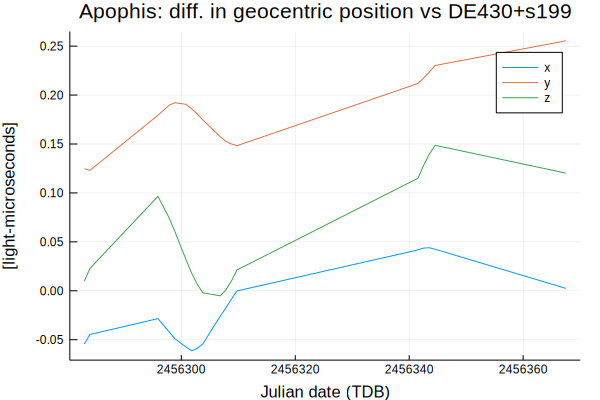

In [189]:
plot( tv[2:end], (x_ae_ti - x_ae_jpl)[2:end,1]*au*(1e6/299792.458), label="x")#, marker=:cross)
plot!(tv[2:end], (x_ae_ti - x_ae_jpl)[2:end,2]*au*(1e6/299792.458), label="y")#, marker=:cross)
plot!(tv[2:end], (x_ae_ti - x_ae_jpl)[2:end,3]*au*(1e6/299792.458), label="z")#, marker=:cross)
title!("Apophis: diff. in geocentric position vs DE430+s199")
ylabel!("[light-microseconds]")
xlabel!("Julian date (TDB)")

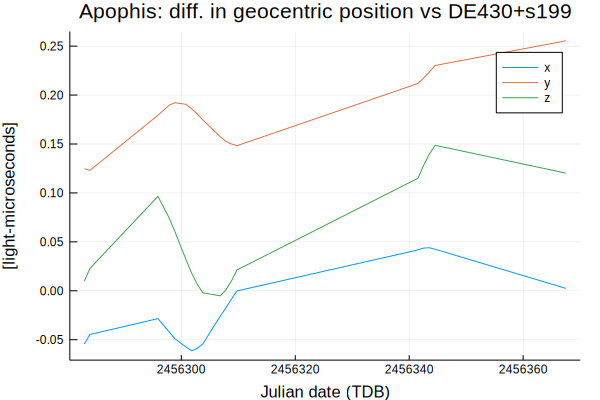

In [190]:
plot( tv[2:end], (x_ae_ti - x_ae_jpl)[2:end,1]*au*(1e6/299792.458), label="x")#, marker=:cross)
plot!(tv[2:end], (x_ae_ti - x_ae_jpl)[2:end,2]*au*(1e6/299792.458), label="y")#, marker=:cross)
plot!(tv[2:end], (x_ae_ti - x_ae_jpl)[2:end,3]*au*(1e6/299792.458), label="z")#, marker=:cross)
title!("Apophis: diff. in geocentric position vs DE430+s199")
ylabel!("[light-microseconds]")
xlabel!("Julian date (TDB)")

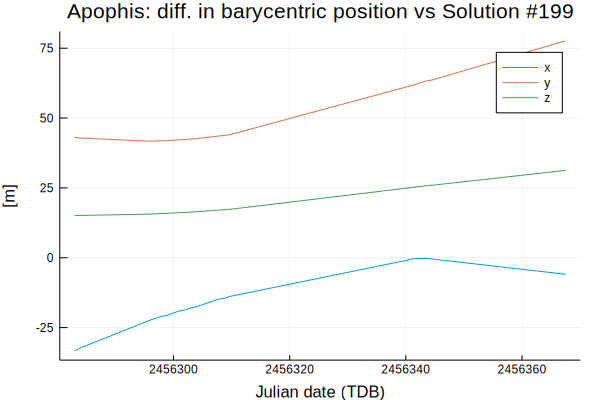

In [191]:
plot( tv[2:end], (apophis_ti-apophis_jpl)[2:end,1]*1000au, label="x")#, marker=:cross)
plot!(tv[2:end], (apophis_ti-apophis_jpl)[2:end,2]*1000au, label="y")#, marker=:cross)
plot!(tv[2:end], (apophis_ti-apophis_jpl)[2:end,3]*1000au, label="z")#, marker=:cross)
title!("Apophis: diff. in barycentric position vs Solution #199")
ylabel!("[m]")
xlabel!("Julian date (TDB)")

## Propagation up to 2021/2038

#recover integration from .jld file

#using JLD

vars = ["tv1", "xv1", "tvS1", "xvS1", "gvS1"] #names of variables
vars_2038 = ["tv1_2038", "xv1_2038", "tvS1_2038", "xvS1_2038", "gvS1_2038"] #names of variables
filename_2038 = string("Apophis_2038_jt.jld")
for i in eachindex(vars)
    ex_2038 = Symbol(vars_2038[i])
    @eval $ex_2038 = load($filename_2038, vars[$i])
end

tv1_2038

apophis_TI_diff = xv1_2038[:, Apophis.apophisdofs](A2_lsqfit_deldop)-xv1_2038[:, Apophis.apophisdofs]();

ae_TI_0 = xv1_2038[:, Apophis.apophisdofs]()-xv1_2038[:, Apophis.earthdofs]()
d_Ap_Ea_0 = sqrt.(ae_TI_0[:,1].^2 + ae_TI_0[:,2].^2 + ae_TI_0[:,3].^2)

ae_TI_A2 = xv1_2038[:, Apophis.apophisdofs](A2_lsqfit_deldop)-xv1_2038[:, Apophis.earthdofs]()
d_Ap_Ea_A2 = sqrt.(ae_TI_A2[:,1].^2 + ae_TI_A2[:,2].^2 + ae_TI_A2[:,3].^2)
;

gr()

_2021_approach = 3200:3263
plot(tv1_2038[_2021_approach].-tv1_2038[3200], (d_Ap_Ea_A2-d_Ap_Ea_0)[_2021_approach].*au)

findfirst(x->x>datetime2julian(DateTime(2021,1,1)), tv1_2038)

findlast(x->x<datetime2julian(DateTime(2021,4,1)), tv1_2038)

## Plots for the poster

In [169]:
pgfplots(grid=:false, framestyle=:box)

Plots.PGFPlotsBackend()

In [163]:
font_size = 14

14

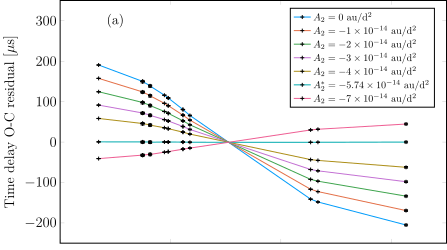

In [164]:
A2_plot = -5.74846133680956 # A2_lsqfit_deldop
A2_label_str = @sprintf "\$A_2^* = -5.74 \\times 10^{-14} \$ au/d\$^2\$"
plot(
    tv_jpl_utc_jul[delay_index].-t0,
    residual_td(), yerror = tdelay_jpl_obs_sigma,
    marker=:cross,
    label = "\$A_2 = 0\$ au/d\$^2\$",
    legend = :topright,
    tickfont=font(font_size),
    guidefont=font(font_size),
    legendfont = font(font_size-4),
    xticks = (1540:30:1640, ()),
    annotations=( 1555, 300, "(a)")
)
for i in 1:4
    a2_lbl_str_i = "\$A_2 = -$i \\times 10^{-14}\$ au/d\$^2\$"
    plot!(
    tv_jpl_utc_jul[delay_index].-t0,
    residual_td(-i), yerror = tdelay_jpl_obs_sigma,
    marker=:cross,
    label = a2_lbl_str_i,
    legend = :topright
)
end
plot!(
    tv_jpl_utc_jul[delay_index].-t0,
    residual_td(A2_plot), yerror = tdelay_jpl_obs_sigma,
    marker=:cross,
    label = A2_label_str,
    legend = :topright
)
plot!(
    tv_jpl_utc_jul[delay_index].-t0,
    residual_td(-7), yerror = tdelay_jpl_obs_sigma,
    marker=:cross,
    label = "\$A_2 = -7 \\times 10^{-14} \$ au/d\$^2\$",
    legend = :topright
)
ylabel!("Time delay O-C residual \$ [\\mu\\mathrm{s}] \$")
xlims!(1540, 1645)
#ylims!(-5,4)
ylims!(-250,350)
#xticks!(1540:30:1640, string.(Date.(julian2datetime.(t0 .+ collect(1540:30:1640)))))
#xlabel!("Calendar date")
#savefig("delay_residuals_A2.pdf")

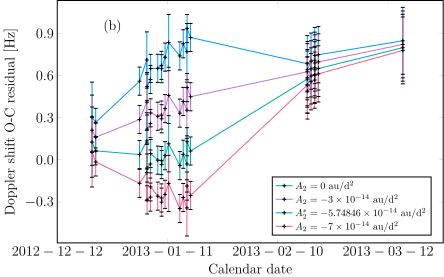

In [165]:
A2_plot = -5.74846133680956 # A2_lsqfit_deldop
A2_label_str = @sprintf "\$A_2^* = -5.74846 \\times 10^{-14} \$ au/d\$^2\$"
plot(
    tv_jpl_utc_jul[doppler_index].-t0,
    residual_ds(), yerror = dshift_jpl_obs_sigma,
    marker=:cross,
    label = "\$A_2 = 0\$ au/d\$^2\$",
    legend = :bottomright,
    tickfont=font(font_size),
    guidefont=font(font_size),
    legendfont = font(font_size-4),
    annotations=( 1555, 0.95, "(b)")
)
for i in 3:3
    a2_lbl_str_i = "\$A_2 = -$i \\times 10^{-14} \$ au/d\$^2\$"
    plot!(
    tv_jpl_utc_jul[doppler_index].-t0,
    residual_ds(-i), yerror = dshift_jpl_obs_sigma,
    marker=:cross,
    label = a2_lbl_str_i,
    #legend = :topright,
    color=3+1
)
end
plot!(
    tv_jpl_utc_jul[doppler_index].-t0,
    residual_ds(A2_plot), yerror = dshift_jpl_obs_sigma,
    marker=:cross,
    label = A2_label_str,
    #legend = :topright,
    color=6
)
plot!(
    tv_jpl_utc_jul[doppler_index].-t0,
    residual_ds(-8), yerror = dshift_jpl_obs_sigma,
    marker=:cross,
    label = "\$A_2 = -7 \\times 10^{-14} \$ au/d\$^2\$",
    #legend = :topright,
    color=7
)
ylabel!("Doppler shift O-C residual \$ [\\mathrm{Hz}] \$")
xlims!(1540, 1645)
#ylims!(-5,4)
#ylims!(-250,350)
xticks!(1540:30:1640, string.(Date.(julian2datetime.(t0 .+ collect(1540:30:1640)))))
xlabel!("Calendar date")
#savefig("doppler_residuals_A2.pdf")

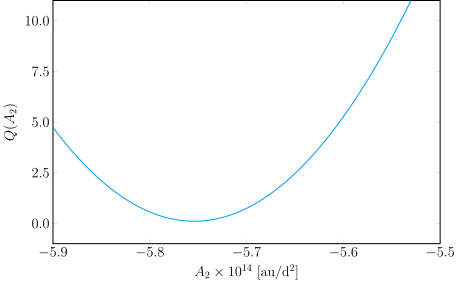

In [184]:
plot(
    A2_vals,
    Q_A2_deldop.(A2_vals),
    leg=false,
    tickfont=font(font_size),
    guidefont=font(font_size),
    legendfont = font(font_size-4)
)
xlabel!("\$A_2 \\times 10^{14} \$ [au/d\$^2]\$")
ylabel!("\$Q(A_2)\$")
#title!("Mean square residual vs A2")
ylims!(-1, 11)
xlims!(-5.9, -5.5)
#savefig("Q_vs_A2.pdf")